In [297]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import pylab
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import random


%matplotlib inline

In [2]:
car_path = 'vehicles/**/*.png'
non_car_path = 'non-vehicles/**/*.png'

In [3]:
# function to read all image files from a given path and return them
def read_images(path):
    imgs = glob.glob(path)
    return imgs

car_images = []
non_car_images = []
# reads all car images from car paths and saves them to this list
car_images = read_images(car_path)
# reads all non- car images from car paths and saves them to this list
non_car_images = read_images(non_car_path)
    
print('car images count', len(car_images))
print('non car images count', len(non_car_images))
        

car images count 8792
non car images count 8968


In [4]:
# function to compute flatten, binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        # return hog features and image visulaized
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        # return feature vector only
        return features

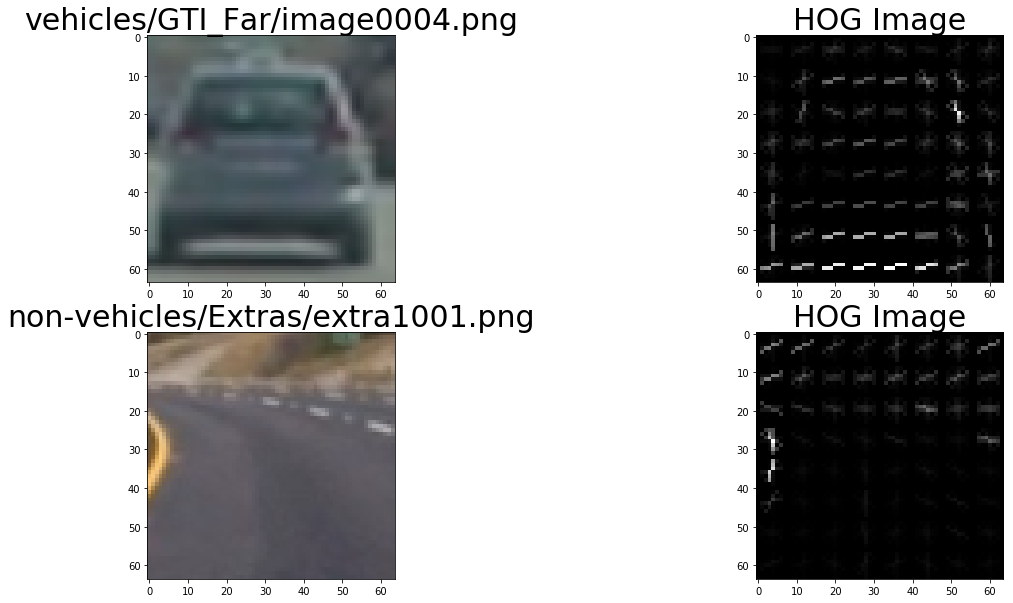

In [303]:
# visualizing hog_features on some random images.
index = random.randint(0, 20)
car1 = mpimg.imread(car_images[index])
nc1 = mpimg.imread(non_car_images[index])
gray_car = cv2.cvtColor(car1, cv2.COLOR_RGB2GRAY)
gray_nc = cv2.cvtColor(nc1, cv2.COLOR_RGB2GRAY)
_, hog_img_car = get_hog_features(gray_car,11, 8, 2, vis=True, feature_vec=True)
_, hog_img_nc = get_hog_features(gray_nc,11, 8, 2, vis=True, feature_vec=True)
f, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.ravel()
axs[0].imshow(car1)
axs[0].set_title(car_images[index], fontsize=30)
axs[1].imshow(hog_img_car, cmap='gray')
axs[1].set_title('HOG Image', fontsize=30)

axs[2].imshow(nc1)
axs[2].set_title(non_car_images[index], fontsize=30)
axs[3].imshow(hog_img_nc, cmap='gray')
axs[3].set_title('HOG Image', fontsize=30)

pylab.savefig("./output_images/random.png");

In [45]:
# final hog parameters 

colorspace = 'YCrCb' # Other possible values - RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Other possible values - 0, 1, 2, or "ALL"
spatial_size = (16,16)
hist_bins = 16


In [46]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, spatial_feat=True, hist_feat=True, hog_feat=True, cspace='RGB', 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_size=(32, 32), hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = []
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # compute spatial features if flag is set and append to feature list
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        # compute histogram color features if flag is set and append to feature list
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)

        # compute hog features if flag is set and append to feature list
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            # if ALL get hog features for all channels of the image and append them to list or else
            # append only the selected channel hog features.
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))     
    # Return list of feature vectors
    return features

In [48]:
# extract car and non car features.

car_features = []
notcar_features = []
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size, hist_bins = hist_bins)
notcar_features = extract_features(non_car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spatial_size, hist_bins= hist_bins)

In [49]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = None
# normalize data using the Standard Scaler.
X_scaler = StandardScaler().fit(X) # builds scaler for the dataset (computing statistics as relevant)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7284


In [50]:
# train a classifer

svc = None
# linear SVM with linear kernel
svc = LinearSVC()
t=time.time()
# train the classifier
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# save to pickle file for future use.
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["X_scaler"] = X_scaler
pickle.dump( dist_pickle, open( "svc.p", "wb" ) )


115.03 Seconds to train SVC...
Test Accuracy of SVC =  0.9879


In [51]:
# testing classifier with random inputs
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
0.04028 Seconds to predict 10 labels with SVC


In [261]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, y_range, cspace, hog_channel, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
  
    rects = []   
    img = img.astype(np.float32)/255
    ystart = y_range[0]
    ystop = y_range[1]
#     print(ystart, ystop)
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: 
        ctrans_tosearch = np.copy(img_tosearch)

#     print(scale)
    if scale != 1:
        imshape = ctrans_tosearch.shape
#         print('shape', imshape)
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
   
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define number of x & y blocks
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
#     nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
#     nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
#     nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
#     cells_per_step = 4 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
#     print(nxblocks, nyblocks)
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
#             print('test pred', test_prediction)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # append bounding box to list of boxes to be returned.
                rects.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return rects

In [222]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

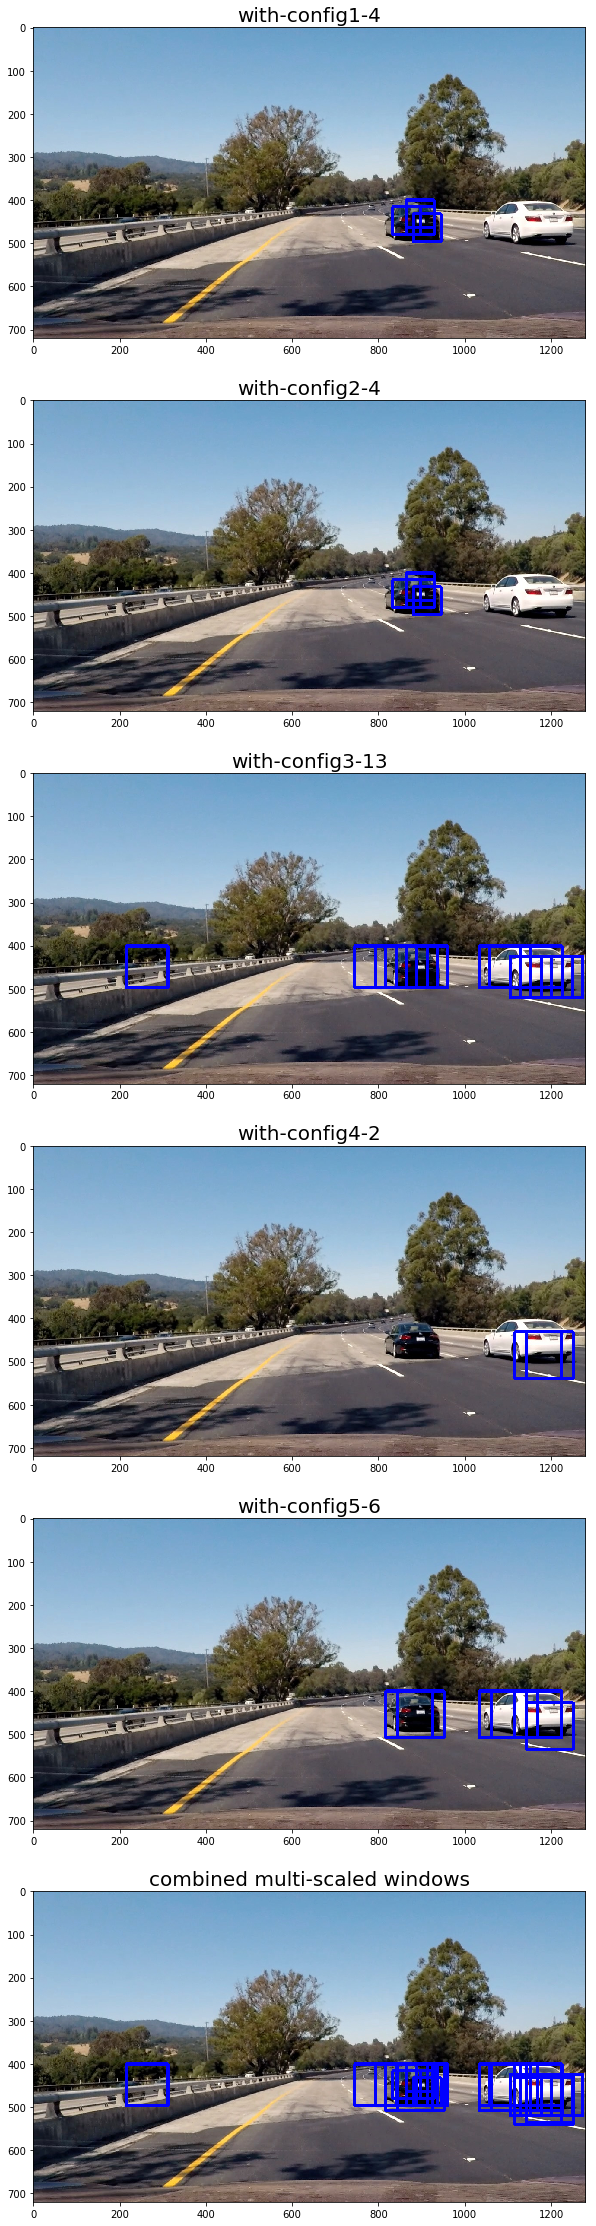

In [306]:
# testing find cars with various scales (multi-scale window approach) and combine the boxes detected 
# and plot onto an image.

# scale1 = 2.0
# scale2 = 1.5
# scale3 = 1.5
# scale4 = 1.0
# scale5 = 3.0
# ystart = 400
# ystop = 650
# y_range1 = (400,650)
# y_range2 = (400,500)
# y_range3 = (400,650)
# y_range4 = (400,470)
y_range1 = (400, 532)
y_range2 = (400, 500)
y_range3 = (400, 650)
y_range4 = (432, 598)
y_range5 = (400, 660)
y_range6 = (400, 660)
scale1 = 1.0
scale2 = 1.0
scale3 = 1.5
scale4 = 1.7
scale5 = 1.7
# scale6 = 2.0
test_img = mpimg.imread('test_images/test4.jpg')
# test_img = mpimg.imread('frame_45/frame1.jpg')
# test_img = mpimg.imread('frame_7/frame8.jpg')

rects1 = find_cars(test_img, y_range1, colorspace, hog_channel, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
rects2 = find_cars(test_img, y_range2, colorspace, hog_channel, scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
rects3 = find_cars(test_img, y_range3, colorspace, hog_channel, scale3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
rects4 = find_cars(test_img, y_range4, colorspace, hog_channel, scale4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
rects5 = find_cars(test_img, y_range5, colorspace, hog_channel, scale5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# rects6 = find_cars(test_img, y_range6, colorspace, hog_channel, scale6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

rects_combined = []
rects_combined.extend(rects1)
rects_combined.extend(rects2)
rects_combined.extend(rects3)
rects_combined.extend(rects4)
rects_combined.extend(rects5)
# rects_combined.extend(rects6)
f, axs = plt.subplots(6, 1, figsize=(40,40))
axs = axs.ravel()
axs[0].imshow(draw_boxes(test_img, rects1))
axs[0].set_title('with-config1-'+str(len(rects1)), fontsize=20)
axs[1].imshow(draw_boxes(test_img, rects2))
axs[1].set_title('with-config2-'+str(len(rects2)), fontsize=20)
axs[2].imshow(draw_boxes(test_img, rects3))
axs[2].set_title('with-config3-'+str(len(rects3)), fontsize=20)
axs[3].imshow(draw_boxes(test_img, rects4))
axs[3].set_title('with-config4-'+str(len(rects4)), fontsize=20)
axs[4].imshow(draw_boxes(test_img, rects5))
axs[4].set_title('with-config5-'+str(len(rects5)), fontsize=20)
# axs[5].imshow(draw_boxes(test_img, rects6))
# axs[5].set_title('with-config6-'+str(len(rects6)), fontsize=20)

axs[5].imshow(draw_boxes(test_img, rects_combined))
axs[5].set_title('combined multi-scaled windows', fontsize=20)
pylab.savefig("./output_images/find_cars.png");

In [37]:
# function to iterate through the bounding boxes and increment count for
# each pixel inside the box.
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# function to threshold a given heat-map and reject the false positives.
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# function to draw labels on to a copy of the image.
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heatmap without thresholding


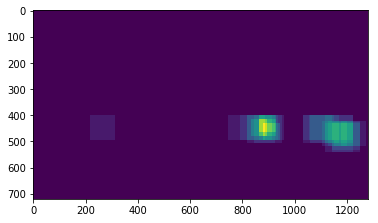

In [311]:
# Add heat to each box in box list
# test_img = mpimg.imread('frame_45/frame1.jpg')
# test_img = mpimg.imread('frame_7/frame8.jpg')
test_img = mpimg.imread('test_images/test4.jpg')
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
heat = add_heat(heat,rects_combined) 
plt.figure()
print('heatmap without thresholding')
plt.imshow(heat)
pylab.savefig("./output_images/without_thresholding.png");

heatmap with thresholding
2 cars found


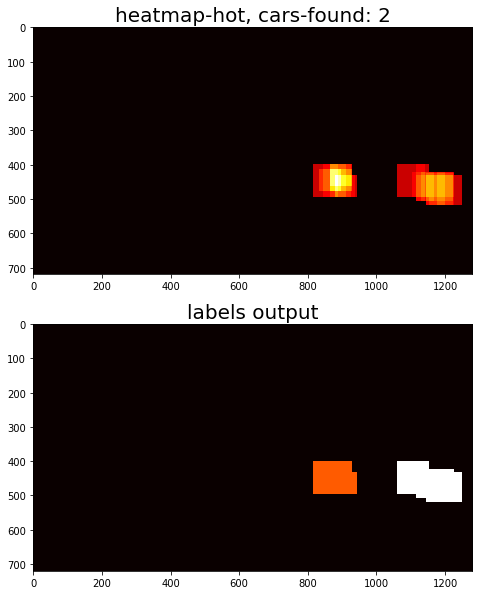

In [314]:
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)
# # Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# # Find final boxes from heatmap using label function
print('heatmap with thresholding')
labels = label(heatmap) # Label features in an image. Anything nonzero is typically counted as a feature.
print(labels[1], 'cars found')
f, axs = plt.subplots(2, 1, figsize=(20,10))
axs = axs.ravel()
axs[0].imshow(heatmap, cmap='hot')
axs[0].set_title('heatmap-hot, cars-found: ' + str(labels[1]), fontsize=20)
axs[1].imshow(labels[0], cmap='hot')
axs[1].set_title('labels output', fontsize=20)
pylab.savefig("./output_images/with_thresholding.png");

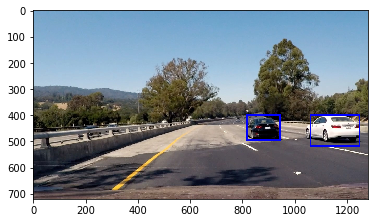

In [315]:

draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
plt.figure()
plt.imshow(draw_img)
pylab.savefig("./output_images/final_withboxes.png");

In [254]:
# consolidates the above functions & steps into a single function and this can be run on individual images
# for testing and display.
def process_image(img):
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16,16)
    hist_bins = 16

    scale1 = 1.0
    y_range1 = (400, 532)
    rects1 = find_cars(img, y_range1, colorspace, hog_channel, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale2 = 1.0
    y_range2 = (400, 500)
    rects2 = find_cars(img, y_range2, colorspace, hog_channel, scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale3 = 1.5
    y_range3 = (400, 650)
    rects3 = find_cars(img, y_range3, colorspace, hog_channel, scale3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale4 = 1.7
    y_range4 = (432, 598)
    rects4 = find_cars(img, y_range4, colorspace, hog_channel, scale4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale5 = 1.7
    y_range5 = (400, 660)
    rects5 = find_cars(img, y_range5, colorspace, hog_channel, scale5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# y_range6 = (460, 660)

    rects_combined = []
    rects_combined.extend(rects1)
    rects_combined.extend(rects2)
    rects_combined.extend(rects3)
    rects_combined.extend(rects4)
    rects_combined.extend(rects5)
    
    heat_img = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat_img,rects_combined) 
    heat = apply_threshold(heat,3.0)
    # # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # # Find final boxes from heatmap using label function
    print('heatmap with thresholding')
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

heatmap with thresholding
heatmap with thresholding
heatmap with thresholding
heatmap with thresholding
heatmap with thresholding
heatmap with thresholding


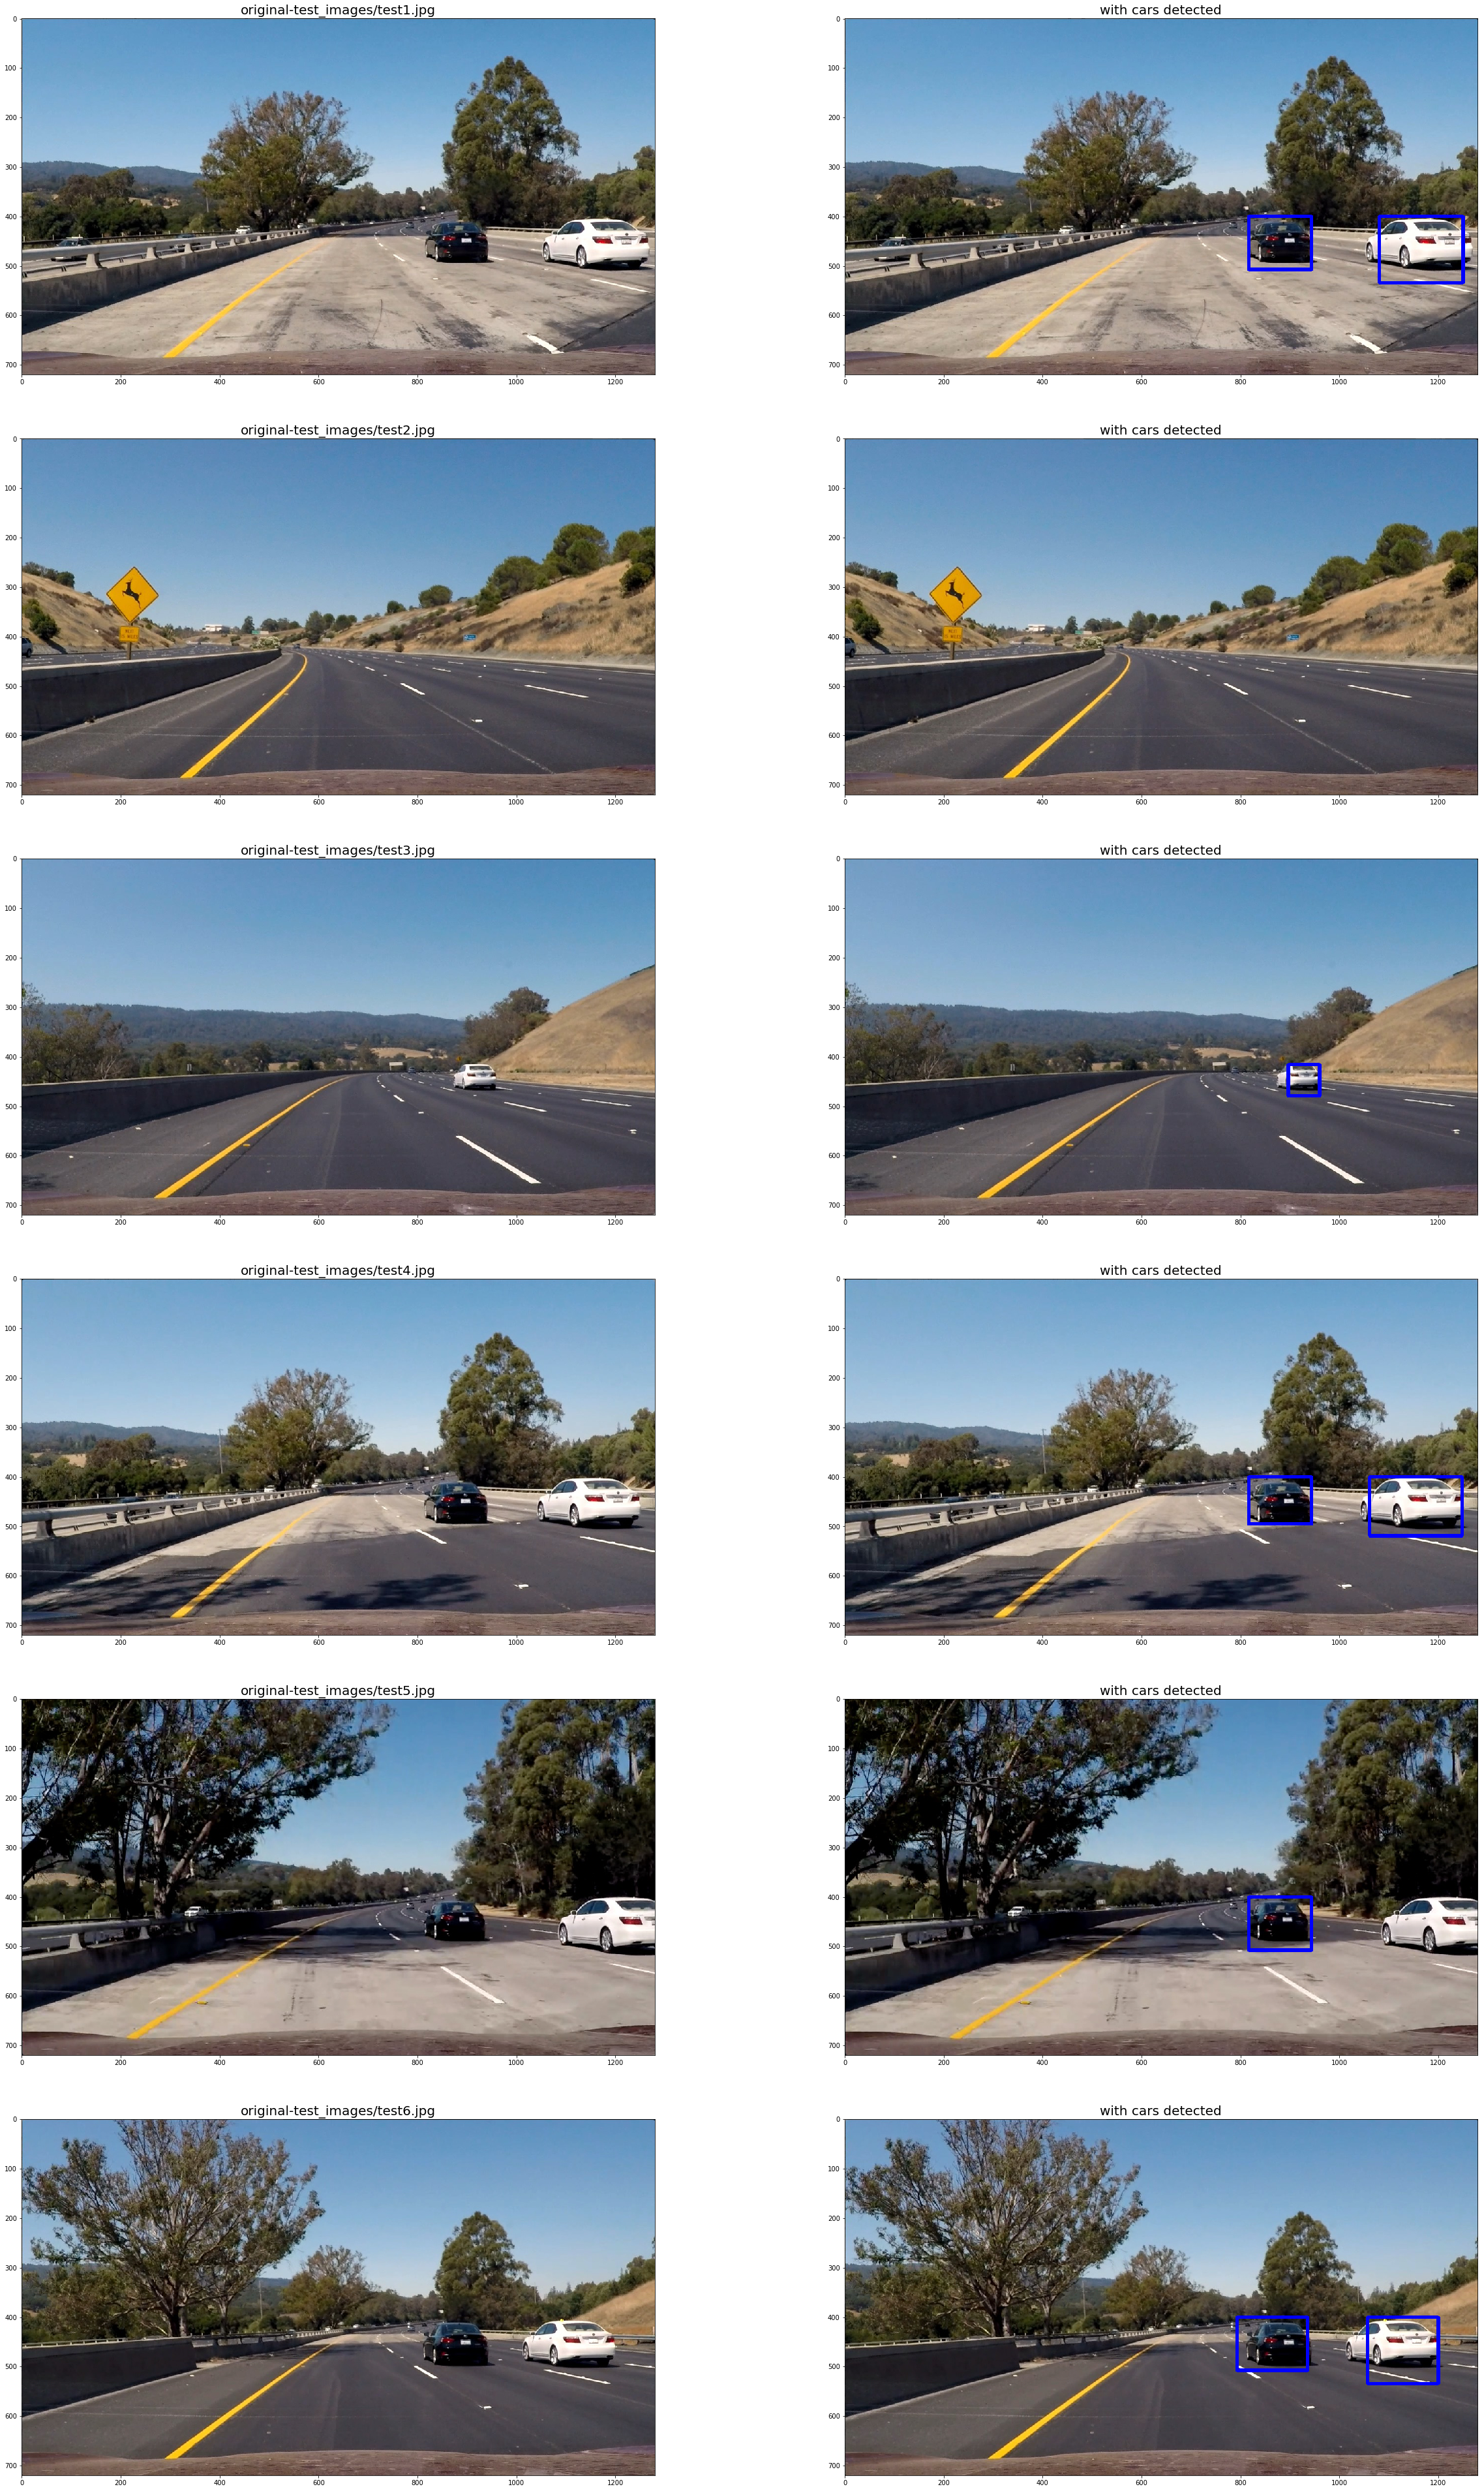

In [316]:
# test_imgs = glob.glob('fram_45/*.jpg')
# test_imgs = glob.glob('frame_42/*.jpg')
# test_imgs = glob.glob('fram_7/*.jpg')
test_imgs = glob.glob('test_images/*.jpg')
imgsize = len(test_imgs)
f, axs = plt.subplots(imgsize, 2, figsize=(40,70))
f.subplots_adjust(hspace = .1, wspace=.3)
axs = axs.ravel()
i = 0
for test_img_path in test_imgs:
    test_img = mpimg.imread(test_img_path)
    test_img_rects = process_image(test_img)
    axs[i].imshow(test_img, cmap='gray')
    axs[i].set_title('original-'+test_img_path, fontsize=20)
    i += 1
    axs[i].imshow(test_img_rects, cmap='gray')
    title = 'with cars detected'
    axs[i].set_title('with cars detected', fontsize=20)
    i += 1

pylab.savefig("./output_images/all_test_images.png");

In [89]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18
heatmap with thresholding
[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


  0%|          | 0/39 [00:00<?, ?it/s]

400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


  3%|▎         | 1/39 [00:01<01:02,  1.65s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


  5%|▌         | 2/39 [00:03<01:01,  1.65s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 

  8%|▊         | 3/39 [00:05<01:00,  1.68s/it]

18
heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 10%|█         | 4/39 [00:06<00:58,  1.67s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 13%|█▎        | 5/39 [00:08<00:59,  1.76s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 15%|█▌        | 6/39 [00:10<00:55,  1.67s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 18%|█▊        | 7/39 [00:11<00:50,  1.57s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 21%|██        | 8/39 [00:12<00:48,  1.56s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 23%|██▎       | 9/39 [00:14<00:45,  1.50s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 26%|██▌       | 10/39 [00:15<00:43,  1.49s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 28%|██▊       | 11/39 [00:17<00:41,  1.49s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 31%|███       | 12/39 [00:18<00:39,  1.47s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 33%|███▎      | 13/39 [00:20<00:38,  1.46s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 36%|███▌      | 14/39 [00:22<00:39,  1.58s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 38%|███▊      | 15/39 [00:24<00:41,  1.75s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18

 41%|████      | 16/39 [00:25<00:40,  1.75s/it]


heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 44%|████▎     | 17/39 [00:27<00:36,  1.64s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 46%|████▌     | 18/39 [00:28<00:32,  1.54s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 49%|████▊     | 19/39 [00:30<00:33,  1.68s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 51%|█████▏    | 20/39 [00:32<00:34,  1.81s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 54%|█████▍    | 21/39 [00:34<00:30,  1.68s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 56%|█████▋    | 22/39 [00:35<00:27,  1.59s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 59%|█████▉    | 23/39 [00:36<00:24,  1.53s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 62%|██████▏   | 24/39 [00:38<00:23,  1.54s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)


 64%|██████▍   | 25/39 [00:40<00:22,  1.63s/it]

93 18
heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 67%|██████▋   | 26/39 [00:41<00:20,  1.60s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93

 69%|██████▉   | 27/39 [00:43<00:20,  1.69s/it]

 18
heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 72%|███████▏  | 28/39 [00:46<00:22,  2.01s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7


 74%|███████▍  | 29/39 [00:49<00:21,  2.18s/it]

shape (260, 1280, 3)
93 18
heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)


 77%|███████▋  | 30/39 [00:51<00:19,  2.18s/it]

93 18
heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 79%|███████▉  | 31/39 [00:53<00:18,  2.26s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 82%|████████▏ | 32/39 [00:55<00:15,  2.27s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 85%|████████▍ | 33/39 [00:57<00:12,  2.13s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 87%|████████▋ | 34/39 [00:59<00:09,  1.98s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 90%|████████▉ | 35/39 [01:00<00:07,  1.84s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)

 92%|█████████▏| 36/39 [01:02<00:05,  1.79s/it]


93 18
heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 95%|█████████▍| 37/39 [01:04<00:03,  1.72s/it]

heatmap with thresholding
400 532
1.0
159 15
400 500
1.0
159 11
400 650
1.5
shape (250, 1280, 3)
105 19
432 598
1.7
shape (166, 1280, 3)
93 11
400 660
1.7
shape (260, 1280, 3)
93 18


 97%|█████████▋| 38/39 [01:05<00:01,  1.66s/it]

heatmap with thresholding


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 55.9 s, sys: 8.4 s, total: 1min 4s
Wall time: 1min 7s


In [293]:
class Detection():
    def __init__(self):
        self.prev_detection = []

    def add(self, rects):
        self.prev_detection.append(rects)
        if len(self.prev_detection) > 20:
            # throw out old detections, keep newest n
            self.prev_detection = self.prev_detection[len(self.prev_detection)-20:]
            
def process_frame(img):
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16,16)
    hist_bins = 16

    scale1 = 1.0
    y_range1 = (400, 532)
    rects1 = find_cars(img, y_range1, colorspace, hog_channel, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale2 = 1.0
    y_range2 = (400, 500)
    rects2 = find_cars(img, y_range2, colorspace, hog_channel, scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale3 = 1.5
    y_range3 = (400, 650)
    rects3 = find_cars(img, y_range3, colorspace, hog_channel, scale3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale4 = 1.7
    y_range4 = (432, 598)
    rects4 = find_cars(img, y_range4, colorspace, hog_channel, scale4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale5 = 1.7
    y_range5 = (400, 660)
    rects5 = find_cars(img, y_range5, colorspace, hog_channel, scale5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # y_range6 = (460, 660)

    rects_combined = []
    rects_combined.extend(rects1)
    rects_combined.extend(rects2)
    rects_combined.extend(rects3)
    rects_combined.extend(rects4)
    rects_combined.extend(rects5)
    
    if len(rects_combined) > 0:
        detection.add(rects_combined)
        
    heat_img = np.zeros_like(img[:,:,0]).astype(np.float)
    for rects in detection.prev_detection:
        heat_img = add_heat(heat_img,rects) 
#     heat = add_heat(heat_img,rects_combined) 
    heat = apply_threshold(heat_img, 15 + (len(detection.prev_detection)//2))
#     heat = apply_threshold(heat_img, 20)
    # # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # # Find final boxes from heatmap using label function
    print('heatmap with thresholding')
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [294]:
detection = Detection()
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
# clip_test = VideoFileClip('project_video.mp4').subclip(6,8)
# clip_test = VideoFileClip('project_video.mp4').subclip(40,50)
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

heatmap with thresholding
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



  0%|          | 1/1261 [00:02<46:01,  2.19s/it]

heatmap with thresholding



  0%|          | 2/1261 [00:04<45:07,  2.15s/it]

heatmap with thresholding



  0%|          | 3/1261 [00:05<41:25,  1.98s/it]

heatmap with thresholding



  0%|          | 4/1261 [00:08<43:58,  2.10s/it]

heatmap with thresholding



  0%|          | 5/1261 [00:09<41:30,  1.98s/it]

heatmap with thresholding



  0%|          | 6/1261 [00:11<40:11,  1.92s/it]

heatmap with thresholding



  1%|          | 7/1261 [00:13<37:29,  1.79s/it]

heatmap with thresholding



  1%|          | 8/1261 [00:14<36:30,  1.75s/it]

heatmap with thresholding



  1%|          | 9/1261 [00:16<34:12,  1.64s/it]

heatmap with thresholding



  1%|          | 10/1261 [00:17<32:26,  1.56s/it]

heatmap with thresholding



  1%|          | 11/1261 [00:19<32:24,  1.56s/it]

heatmap with thresholding



  1%|          | 12/1261 [00:20<33:55,  1.63s/it]

heatmap with thresholding



  1%|          | 13/1261 [00:22<35:15,  1.69s/it]

heatmap with thresholding



  1%|          | 14/1261 [00:25<39:45,  1.91s/it]

heatmap with thresholding



  1%|          | 15/1261 [00:26<37:58,  1.83s/it]

heatmap with thresholding



  1%|▏         | 16/1261 [00:28<37:36,  1.81s/it]

heatmap with thresholding



  1%|▏         | 17/1261 [00:30<39:25,  1.90s/it]

heatmap with thresholding



  1%|▏         | 18/1261 [00:32<40:39,  1.96s/it]

heatmap with thresholding



  2%|▏         | 19/1261 [00:34<39:02,  1.89s/it]

heatmap with thresholding



  2%|▏         | 20/1261 [00:36<42:04,  2.03s/it]

heatmap with thresholding



  2%|▏         | 21/1261 [00:38<41:33,  2.01s/it]

heatmap with thresholding



  2%|▏         | 22/1261 [00:40<39:11,  1.90s/it]

heatmap with thresholding



  2%|▏         | 23/1261 [00:42<37:04,  1.80s/it]

heatmap with thresholding



  2%|▏         | 24/1261 [00:43<35:00,  1.70s/it]

heatmap with thresholding



  2%|▏         | 25/1261 [00:45<34:16,  1.66s/it]

heatmap with thresholding



  2%|▏         | 26/1261 [00:46<34:40,  1.68s/it]

heatmap with thresholding



  2%|▏         | 27/1261 [00:48<33:09,  1.61s/it]

heatmap with thresholding



  2%|▏         | 28/1261 [00:49<33:04,  1.61s/it]

heatmap with thresholding



  2%|▏         | 29/1261 [00:51<32:44,  1.59s/it]

heatmap with thresholding



  2%|▏         | 30/1261 [00:53<33:37,  1.64s/it]

heatmap with thresholding



  2%|▏         | 31/1261 [00:54<32:31,  1.59s/it]

heatmap with thresholding



  3%|▎         | 32/1261 [00:56<31:06,  1.52s/it]

heatmap with thresholding



  3%|▎         | 33/1261 [00:57<30:16,  1.48s/it]

heatmap with thresholding



  3%|▎         | 34/1261 [00:58<29:45,  1.46s/it]

heatmap with thresholding



  3%|▎         | 35/1261 [01:00<29:11,  1.43s/it]

heatmap with thresholding



  3%|▎         | 36/1261 [01:01<28:50,  1.41s/it]

heatmap with thresholding



  3%|▎         | 37/1261 [01:02<28:51,  1.41s/it]

heatmap with thresholding



  3%|▎         | 38/1261 [01:04<29:53,  1.47s/it]

heatmap with thresholding



  3%|▎         | 39/1261 [01:06<30:27,  1.50s/it]

heatmap with thresholding



  3%|▎         | 40/1261 [01:07<32:40,  1.61s/it]

heatmap with thresholding



  3%|▎         | 41/1261 [01:09<33:01,  1.62s/it]

heatmap with thresholding



  3%|▎         | 42/1261 [01:11<32:55,  1.62s/it]

heatmap with thresholding



  3%|▎         | 43/1261 [01:12<31:29,  1.55s/it]

heatmap with thresholding



  3%|▎         | 44/1261 [01:14<30:56,  1.53s/it]

heatmap with thresholding



  4%|▎         | 45/1261 [01:15<31:06,  1.54s/it]

heatmap with thresholding



  4%|▎         | 46/1261 [01:17<30:55,  1.53s/it]

heatmap with thresholding



  4%|▎         | 47/1261 [01:18<31:12,  1.54s/it]

heatmap with thresholding



  4%|▍         | 48/1261 [01:20<32:08,  1.59s/it]

heatmap with thresholding



  4%|▍         | 49/1261 [01:21<31:22,  1.55s/it]

heatmap with thresholding



  4%|▍         | 50/1261 [01:23<31:28,  1.56s/it]

heatmap with thresholding



  4%|▍         | 51/1261 [01:25<31:32,  1.56s/it]

heatmap with thresholding



  4%|▍         | 52/1261 [01:26<31:55,  1.58s/it]

heatmap with thresholding



  4%|▍         | 53/1261 [01:28<31:38,  1.57s/it]

heatmap with thresholding



  4%|▍         | 54/1261 [01:29<31:00,  1.54s/it]

heatmap with thresholding



  4%|▍         | 55/1261 [01:31<31:17,  1.56s/it]

heatmap with thresholding



  4%|▍         | 56/1261 [01:32<30:47,  1.53s/it]

heatmap with thresholding



  5%|▍         | 57/1261 [01:34<31:58,  1.59s/it]

heatmap with thresholding



  5%|▍         | 58/1261 [01:36<32:15,  1.61s/it]

heatmap with thresholding



  5%|▍         | 59/1261 [01:37<32:16,  1.61s/it]

heatmap with thresholding



  5%|▍         | 60/1261 [01:39<31:55,  1.59s/it]

heatmap with thresholding



  5%|▍         | 61/1261 [01:40<31:37,  1.58s/it]

heatmap with thresholding



  5%|▍         | 62/1261 [01:42<32:25,  1.62s/it]

heatmap with thresholding



  5%|▍         | 63/1261 [01:44<33:47,  1.69s/it]

heatmap with thresholding



  5%|▌         | 64/1261 [01:46<35:16,  1.77s/it]

heatmap with thresholding



  5%|▌         | 65/1261 [01:48<35:17,  1.77s/it]

heatmap with thresholding



  5%|▌         | 66/1261 [01:50<36:49,  1.85s/it]

heatmap with thresholding



  5%|▌         | 67/1261 [01:52<37:28,  1.88s/it]

heatmap with thresholding



  5%|▌         | 68/1261 [01:53<35:49,  1.80s/it]

heatmap with thresholding



  5%|▌         | 69/1261 [01:55<35:00,  1.76s/it]

heatmap with thresholding



  6%|▌         | 70/1261 [01:57<33:48,  1.70s/it]

heatmap with thresholding



  6%|▌         | 71/1261 [01:58<32:36,  1.64s/it]

heatmap with thresholding



  6%|▌         | 72/1261 [02:00<33:16,  1.68s/it]

heatmap with thresholding



  6%|▌         | 73/1261 [02:01<32:29,  1.64s/it]

heatmap with thresholding



  6%|▌         | 74/1261 [02:03<32:22,  1.64s/it]

heatmap with thresholding



  6%|▌         | 75/1261 [02:05<33:03,  1.67s/it]

heatmap with thresholding



  6%|▌         | 76/1261 [02:06<33:33,  1.70s/it]

heatmap with thresholding



  6%|▌         | 77/1261 [02:08<34:21,  1.74s/it]

heatmap with thresholding



  6%|▌         | 78/1261 [02:10<36:44,  1.86s/it]

heatmap with thresholding



  6%|▋         | 79/1261 [02:13<38:13,  1.94s/it]

heatmap with thresholding



  6%|▋         | 80/1261 [02:14<37:19,  1.90s/it]

heatmap with thresholding



  6%|▋         | 81/1261 [02:16<37:24,  1.90s/it]

heatmap with thresholding



  7%|▋         | 82/1261 [02:18<35:39,  1.81s/it]

heatmap with thresholding



  7%|▋         | 83/1261 [02:20<34:14,  1.74s/it]

heatmap with thresholding



  7%|▋         | 84/1261 [02:21<33:12,  1.69s/it]

heatmap with thresholding



  7%|▋         | 85/1261 [02:23<32:13,  1.64s/it]

heatmap with thresholding



  7%|▋         | 86/1261 [02:24<31:32,  1.61s/it]

heatmap with thresholding



  7%|▋         | 87/1261 [02:26<30:37,  1.56s/it]

heatmap with thresholding



  7%|▋         | 88/1261 [02:27<29:46,  1.52s/it]

heatmap with thresholding



  7%|▋         | 89/1261 [02:29<29:51,  1.53s/it]

heatmap with thresholding



  7%|▋         | 90/1261 [02:30<30:17,  1.55s/it]

heatmap with thresholding



  7%|▋         | 91/1261 [02:32<30:19,  1.55s/it]

heatmap with thresholding



  7%|▋         | 92/1261 [02:33<30:21,  1.56s/it]

heatmap with thresholding



  7%|▋         | 93/1261 [02:35<29:41,  1.53s/it]

heatmap with thresholding



  7%|▋         | 94/1261 [02:37<31:20,  1.61s/it]

heatmap with thresholding



  8%|▊         | 95/1261 [02:38<32:54,  1.69s/it]

heatmap with thresholding



  8%|▊         | 96/1261 [02:40<31:57,  1.65s/it]

heatmap with thresholding



  8%|▊         | 97/1261 [02:42<31:15,  1.61s/it]

heatmap with thresholding



  8%|▊         | 98/1261 [02:43<30:26,  1.57s/it]

heatmap with thresholding



  8%|▊         | 99/1261 [02:45<30:06,  1.55s/it]

heatmap with thresholding



  8%|▊         | 100/1261 [02:46<29:53,  1.54s/it]

heatmap with thresholding



  8%|▊         | 101/1261 [02:48<30:43,  1.59s/it]

heatmap with thresholding



  8%|▊         | 102/1261 [02:50<32:47,  1.70s/it]

heatmap with thresholding



  8%|▊         | 103/1261 [02:52<34:31,  1.79s/it]

heatmap with thresholding



  8%|▊         | 104/1261 [02:54<35:25,  1.84s/it]

heatmap with thresholding



  8%|▊         | 105/1261 [02:55<34:24,  1.79s/it]

heatmap with thresholding



  8%|▊         | 106/1261 [02:57<32:59,  1.71s/it]

heatmap with thresholding



  8%|▊         | 107/1261 [02:58<32:19,  1.68s/it]

heatmap with thresholding



  9%|▊         | 108/1261 [03:00<31:31,  1.64s/it]

heatmap with thresholding



  9%|▊         | 109/1261 [03:01<30:40,  1.60s/it]

heatmap with thresholding



  9%|▊         | 110/1261 [03:03<31:46,  1.66s/it]

heatmap with thresholding



  9%|▉         | 111/1261 [03:05<31:21,  1.64s/it]

heatmap with thresholding



  9%|▉         | 112/1261 [03:06<31:08,  1.63s/it]

heatmap with thresholding



  9%|▉         | 113/1261 [03:08<30:59,  1.62s/it]

heatmap with thresholding



  9%|▉         | 114/1261 [03:10<30:02,  1.57s/it]

heatmap with thresholding



  9%|▉         | 115/1261 [03:11<30:23,  1.59s/it]

heatmap with thresholding



  9%|▉         | 116/1261 [03:13<31:12,  1.64s/it]

heatmap with thresholding



  9%|▉         | 117/1261 [03:14<30:47,  1.61s/it]

heatmap with thresholding



  9%|▉         | 118/1261 [03:16<30:38,  1.61s/it]

heatmap with thresholding



  9%|▉         | 119/1261 [03:18<32:51,  1.73s/it]

heatmap with thresholding



 10%|▉         | 120/1261 [03:20<31:45,  1.67s/it]

heatmap with thresholding



 10%|▉         | 121/1261 [03:21<31:24,  1.65s/it]

heatmap with thresholding



 10%|▉         | 122/1261 [03:23<30:57,  1.63s/it]

heatmap with thresholding



 10%|▉         | 123/1261 [03:24<30:17,  1.60s/it]

heatmap with thresholding



 10%|▉         | 124/1261 [03:26<30:09,  1.59s/it]

heatmap with thresholding



 10%|▉         | 125/1261 [03:28<30:32,  1.61s/it]

heatmap with thresholding



 10%|▉         | 126/1261 [03:29<30:05,  1.59s/it]

heatmap with thresholding



 10%|█         | 127/1261 [03:31<29:28,  1.56s/it]

heatmap with thresholding



 10%|█         | 128/1261 [03:32<28:54,  1.53s/it]

heatmap with thresholding



 10%|█         | 129/1261 [03:34<29:15,  1.55s/it]

heatmap with thresholding



 10%|█         | 130/1261 [03:35<29:14,  1.55s/it]

heatmap with thresholding



 10%|█         | 131/1261 [03:37<29:29,  1.57s/it]

heatmap with thresholding



 10%|█         | 132/1261 [03:38<29:39,  1.58s/it]

heatmap with thresholding



 11%|█         | 133/1261 [03:40<29:08,  1.55s/it]

heatmap with thresholding



 11%|█         | 134/1261 [03:41<29:06,  1.55s/it]

heatmap with thresholding



 11%|█         | 135/1261 [03:43<28:45,  1.53s/it]

heatmap with thresholding



 11%|█         | 136/1261 [03:44<28:26,  1.52s/it]

heatmap with thresholding



 11%|█         | 137/1261 [03:46<28:15,  1.51s/it]

heatmap with thresholding



 11%|█         | 138/1261 [03:47<27:55,  1.49s/it]

heatmap with thresholding



 11%|█         | 139/1261 [03:49<28:20,  1.52s/it]

heatmap with thresholding



 11%|█         | 140/1261 [03:50<28:14,  1.51s/it]

heatmap with thresholding



 11%|█         | 141/1261 [03:52<28:14,  1.51s/it]

heatmap with thresholding



 11%|█▏        | 142/1261 [03:53<28:13,  1.51s/it]

heatmap with thresholding



 11%|█▏        | 143/1261 [03:55<28:21,  1.52s/it]

heatmap with thresholding



 11%|█▏        | 144/1261 [03:57<28:23,  1.52s/it]

heatmap with thresholding



 11%|█▏        | 145/1261 [03:58<28:11,  1.52s/it]

heatmap with thresholding



 12%|█▏        | 146/1261 [04:00<28:25,  1.53s/it]

heatmap with thresholding



 12%|█▏        | 147/1261 [04:01<28:13,  1.52s/it]

heatmap with thresholding



 12%|█▏        | 148/1261 [04:03<28:24,  1.53s/it]

heatmap with thresholding



 12%|█▏        | 149/1261 [04:04<28:26,  1.53s/it]

heatmap with thresholding



 12%|█▏        | 150/1261 [04:06<28:31,  1.54s/it]

heatmap with thresholding



 12%|█▏        | 151/1261 [04:07<28:23,  1.53s/it]

heatmap with thresholding



 12%|█▏        | 152/1261 [04:09<29:04,  1.57s/it]

heatmap with thresholding



 12%|█▏        | 153/1261 [04:10<29:01,  1.57s/it]

heatmap with thresholding



 12%|█▏        | 154/1261 [04:12<28:39,  1.55s/it]

heatmap with thresholding



 12%|█▏        | 155/1261 [04:14<28:21,  1.54s/it]

heatmap with thresholding



 12%|█▏        | 156/1261 [04:15<28:04,  1.52s/it]

heatmap with thresholding



 12%|█▏        | 157/1261 [04:17<28:15,  1.54s/it]

heatmap with thresholding



 13%|█▎        | 158/1261 [04:18<29:03,  1.58s/it]

heatmap with thresholding



 13%|█▎        | 159/1261 [04:20<29:07,  1.59s/it]

heatmap with thresholding



 13%|█▎        | 160/1261 [04:21<29:26,  1.60s/it]

heatmap with thresholding



 13%|█▎        | 161/1261 [04:23<29:47,  1.63s/it]

heatmap with thresholding



 13%|█▎        | 162/1261 [04:25<30:03,  1.64s/it]

heatmap with thresholding



 13%|█▎        | 163/1261 [04:26<29:43,  1.62s/it]

heatmap with thresholding



 13%|█▎        | 164/1261 [04:28<30:20,  1.66s/it]

heatmap with thresholding



 13%|█▎        | 165/1261 [04:30<30:08,  1.65s/it]

heatmap with thresholding



 13%|█▎        | 166/1261 [04:31<29:36,  1.62s/it]

heatmap with thresholding



 13%|█▎        | 167/1261 [04:33<29:26,  1.61s/it]

heatmap with thresholding



 13%|█▎        | 168/1261 [04:35<29:40,  1.63s/it]

heatmap with thresholding



 13%|█▎        | 169/1261 [04:36<30:13,  1.66s/it]

heatmap with thresholding



 13%|█▎        | 170/1261 [04:38<30:42,  1.69s/it]

heatmap with thresholding



 14%|█▎        | 171/1261 [04:40<29:55,  1.65s/it]

heatmap with thresholding



 14%|█▎        | 172/1261 [04:41<30:16,  1.67s/it]

heatmap with thresholding



 14%|█▎        | 173/1261 [04:43<29:20,  1.62s/it]

heatmap with thresholding



 14%|█▍        | 174/1261 [04:44<28:51,  1.59s/it]

heatmap with thresholding



 14%|█▍        | 175/1261 [04:46<28:50,  1.59s/it]

heatmap with thresholding



 14%|█▍        | 176/1261 [04:48<30:56,  1.71s/it]

heatmap with thresholding



 14%|█▍        | 177/1261 [04:49<29:39,  1.64s/it]

heatmap with thresholding



 14%|█▍        | 178/1261 [04:51<29:14,  1.62s/it]

heatmap with thresholding



 14%|█▍        | 179/1261 [04:53<28:47,  1.60s/it]

heatmap with thresholding



 14%|█▍        | 180/1261 [04:54<28:17,  1.57s/it]

heatmap with thresholding



 14%|█▍        | 181/1261 [04:56<27:31,  1.53s/it]

heatmap with thresholding



 14%|█▍        | 182/1261 [04:57<27:11,  1.51s/it]

heatmap with thresholding



 15%|█▍        | 183/1261 [04:59<28:25,  1.58s/it]

heatmap with thresholding



 15%|█▍        | 184/1261 [05:01<30:24,  1.69s/it]

heatmap with thresholding



 15%|█▍        | 185/1261 [05:02<30:41,  1.71s/it]

heatmap with thresholding



 15%|█▍        | 186/1261 [05:04<31:25,  1.75s/it]

heatmap with thresholding



 15%|█▍        | 187/1261 [05:06<30:54,  1.73s/it]

heatmap with thresholding



 15%|█▍        | 188/1261 [05:08<30:22,  1.70s/it]

heatmap with thresholding



 15%|█▍        | 189/1261 [05:09<29:21,  1.64s/it]

heatmap with thresholding



 15%|█▌        | 190/1261 [05:11<28:31,  1.60s/it]

heatmap with thresholding



 15%|█▌        | 191/1261 [05:13<30:51,  1.73s/it]

heatmap with thresholding



 15%|█▌        | 192/1261 [05:14<31:26,  1.76s/it]

heatmap with thresholding



 15%|█▌        | 193/1261 [05:17<34:29,  1.94s/it]

heatmap with thresholding



 15%|█▌        | 194/1261 [05:19<37:30,  2.11s/it]

heatmap with thresholding



 15%|█▌        | 195/1261 [05:21<35:29,  2.00s/it]

heatmap with thresholding



 16%|█▌        | 196/1261 [05:23<34:18,  1.93s/it]

heatmap with thresholding



 16%|█▌        | 197/1261 [05:25<35:33,  2.00s/it]

heatmap with thresholding



 16%|█▌        | 198/1261 [05:27<33:37,  1.90s/it]

heatmap with thresholding



 16%|█▌        | 199/1261 [05:28<33:00,  1.87s/it]

heatmap with thresholding



 16%|█▌        | 200/1261 [05:30<32:49,  1.86s/it]

heatmap with thresholding



 16%|█▌        | 201/1261 [05:32<30:50,  1.75s/it]

heatmap with thresholding



 16%|█▌        | 202/1261 [05:33<29:24,  1.67s/it]

heatmap with thresholding



 16%|█▌        | 203/1261 [05:35<28:24,  1.61s/it]

heatmap with thresholding



 16%|█▌        | 204/1261 [05:36<27:36,  1.57s/it]

heatmap with thresholding



 16%|█▋        | 205/1261 [05:38<27:05,  1.54s/it]

heatmap with thresholding



 16%|█▋        | 206/1261 [05:39<27:10,  1.55s/it]

heatmap with thresholding



 16%|█▋        | 207/1261 [05:41<27:01,  1.54s/it]

heatmap with thresholding



 16%|█▋        | 208/1261 [05:42<26:59,  1.54s/it]

heatmap with thresholding



 17%|█▋        | 209/1261 [05:44<29:16,  1.67s/it]

heatmap with thresholding



 17%|█▋        | 210/1261 [05:46<31:26,  1.79s/it]

heatmap with thresholding



 17%|█▋        | 211/1261 [05:48<31:01,  1.77s/it]

heatmap with thresholding



 17%|█▋        | 212/1261 [05:50<29:45,  1.70s/it]

heatmap with thresholding



 17%|█▋        | 213/1261 [05:52<30:38,  1.75s/it]

heatmap with thresholding



 17%|█▋        | 214/1261 [05:53<31:24,  1.80s/it]

heatmap with thresholding



 17%|█▋        | 215/1261 [05:55<31:42,  1.82s/it]

heatmap with thresholding



 17%|█▋        | 216/1261 [05:57<30:09,  1.73s/it]

heatmap with thresholding



 17%|█▋        | 217/1261 [05:58<28:50,  1.66s/it]

heatmap with thresholding



 17%|█▋        | 218/1261 [06:00<27:46,  1.60s/it]

heatmap with thresholding



 17%|█▋        | 219/1261 [06:01<27:19,  1.57s/it]

heatmap with thresholding



 17%|█▋        | 220/1261 [06:03<26:57,  1.55s/it]

heatmap with thresholding



 18%|█▊        | 221/1261 [06:04<26:36,  1.53s/it]

heatmap with thresholding



 18%|█▊        | 222/1261 [06:06<26:20,  1.52s/it]

heatmap with thresholding



 18%|█▊        | 223/1261 [06:07<26:26,  1.53s/it]

heatmap with thresholding



 18%|█▊        | 224/1261 [06:09<26:50,  1.55s/it]

heatmap with thresholding



 18%|█▊        | 225/1261 [06:11<28:41,  1.66s/it]

heatmap with thresholding



 18%|█▊        | 226/1261 [06:12<28:39,  1.66s/it]

heatmap with thresholding



 18%|█▊        | 227/1261 [06:14<28:10,  1.63s/it]

heatmap with thresholding



 18%|█▊        | 228/1261 [06:16<27:30,  1.60s/it]

heatmap with thresholding



 18%|█▊        | 229/1261 [06:17<27:00,  1.57s/it]

heatmap with thresholding



 18%|█▊        | 230/1261 [06:19<26:27,  1.54s/it]

heatmap with thresholding



 18%|█▊        | 231/1261 [06:20<27:39,  1.61s/it]

heatmap with thresholding



 18%|█▊        | 232/1261 [06:23<34:43,  2.02s/it]

heatmap with thresholding



 18%|█▊        | 233/1261 [06:26<38:31,  2.25s/it]

heatmap with thresholding



 19%|█▊        | 234/1261 [06:28<34:52,  2.04s/it]

heatmap with thresholding



 19%|█▊        | 235/1261 [06:29<32:48,  1.92s/it]

heatmap with thresholding



 19%|█▊        | 236/1261 [06:31<31:00,  1.81s/it]

heatmap with thresholding



 19%|█▉        | 237/1261 [06:33<30:29,  1.79s/it]

heatmap with thresholding



 19%|█▉        | 238/1261 [06:34<30:00,  1.76s/it]

heatmap with thresholding



 19%|█▉        | 239/1261 [06:36<29:59,  1.76s/it]

heatmap with thresholding



 19%|█▉        | 240/1261 [06:38<31:40,  1.86s/it]

heatmap with thresholding



 19%|█▉        | 241/1261 [06:40<31:39,  1.86s/it]

heatmap with thresholding



 19%|█▉        | 242/1261 [06:42<31:03,  1.83s/it]

heatmap with thresholding



 19%|█▉        | 243/1261 [06:43<29:41,  1.75s/it]

heatmap with thresholding



 19%|█▉        | 244/1261 [06:45<29:03,  1.71s/it]

heatmap with thresholding



 19%|█▉        | 245/1261 [06:47<31:46,  1.88s/it]

heatmap with thresholding



 20%|█▉        | 246/1261 [06:49<32:25,  1.92s/it]

heatmap with thresholding



 20%|█▉        | 247/1261 [06:51<31:52,  1.89s/it]

heatmap with thresholding



 20%|█▉        | 248/1261 [06:53<31:27,  1.86s/it]

heatmap with thresholding



 20%|█▉        | 249/1261 [06:55<30:44,  1.82s/it]

heatmap with thresholding



 20%|█▉        | 250/1261 [06:56<28:50,  1.71s/it]

heatmap with thresholding



 20%|█▉        | 251/1261 [06:58<28:00,  1.66s/it]

heatmap with thresholding



 20%|█▉        | 252/1261 [06:59<27:12,  1.62s/it]

heatmap with thresholding



 20%|██        | 253/1261 [07:01<27:26,  1.63s/it]

heatmap with thresholding



 20%|██        | 254/1261 [07:02<27:01,  1.61s/it]

heatmap with thresholding



 20%|██        | 255/1261 [07:04<27:28,  1.64s/it]

heatmap with thresholding



 20%|██        | 256/1261 [07:06<28:21,  1.69s/it]

heatmap with thresholding



 20%|██        | 257/1261 [07:07<28:04,  1.68s/it]

heatmap with thresholding



 20%|██        | 258/1261 [07:10<30:12,  1.81s/it]

heatmap with thresholding



 21%|██        | 259/1261 [07:11<30:03,  1.80s/it]

heatmap with thresholding



 21%|██        | 260/1261 [07:13<31:23,  1.88s/it]

heatmap with thresholding



 21%|██        | 261/1261 [07:15<31:27,  1.89s/it]

heatmap with thresholding



 21%|██        | 262/1261 [07:17<30:45,  1.85s/it]

heatmap with thresholding



 21%|██        | 263/1261 [07:19<31:43,  1.91s/it]

heatmap with thresholding



 21%|██        | 264/1261 [07:21<30:34,  1.84s/it]

heatmap with thresholding



 21%|██        | 265/1261 [07:22<29:14,  1.76s/it]

heatmap with thresholding



 21%|██        | 266/1261 [07:24<28:17,  1.71s/it]

heatmap with thresholding



 21%|██        | 267/1261 [07:26<30:06,  1.82s/it]

heatmap with thresholding



 21%|██▏       | 268/1261 [07:28<30:11,  1.82s/it]

heatmap with thresholding



 21%|██▏       | 269/1261 [07:30<30:10,  1.82s/it]

heatmap with thresholding



 21%|██▏       | 270/1261 [07:31<29:15,  1.77s/it]

heatmap with thresholding



 21%|██▏       | 271/1261 [07:33<29:32,  1.79s/it]

heatmap with thresholding



 22%|██▏       | 272/1261 [07:35<28:46,  1.75s/it]

heatmap with thresholding



 22%|██▏       | 273/1261 [07:37<30:04,  1.83s/it]

heatmap with thresholding



 22%|██▏       | 274/1261 [07:39<29:40,  1.80s/it]

heatmap with thresholding



 22%|██▏       | 275/1261 [07:41<30:57,  1.88s/it]

heatmap with thresholding



 22%|██▏       | 276/1261 [07:42<29:31,  1.80s/it]

heatmap with thresholding



 22%|██▏       | 277/1261 [07:44<28:22,  1.73s/it]

heatmap with thresholding



 22%|██▏       | 278/1261 [07:45<27:05,  1.65s/it]

heatmap with thresholding



 22%|██▏       | 279/1261 [07:47<27:51,  1.70s/it]

heatmap with thresholding



 22%|██▏       | 280/1261 [07:49<28:36,  1.75s/it]

heatmap with thresholding



 22%|██▏       | 281/1261 [07:51<28:25,  1.74s/it]

heatmap with thresholding



 22%|██▏       | 282/1261 [07:53<29:56,  1.84s/it]

heatmap with thresholding



 22%|██▏       | 283/1261 [07:55<29:53,  1.83s/it]

heatmap with thresholding



 23%|██▎       | 284/1261 [07:56<29:10,  1.79s/it]

heatmap with thresholding



 23%|██▎       | 285/1261 [07:58<29:26,  1.81s/it]

heatmap with thresholding



 23%|██▎       | 286/1261 [08:00<27:44,  1.71s/it]

heatmap with thresholding



 23%|██▎       | 287/1261 [08:01<26:58,  1.66s/it]

heatmap with thresholding



 23%|██▎       | 288/1261 [08:03<28:58,  1.79s/it]

heatmap with thresholding



 23%|██▎       | 289/1261 [08:05<27:42,  1.71s/it]

heatmap with thresholding



 23%|██▎       | 290/1261 [08:06<27:27,  1.70s/it]

heatmap with thresholding



 23%|██▎       | 291/1261 [08:08<26:24,  1.63s/it]

heatmap with thresholding



 23%|██▎       | 292/1261 [08:10<26:27,  1.64s/it]

heatmap with thresholding



 23%|██▎       | 293/1261 [08:11<27:20,  1.69s/it]

heatmap with thresholding



 23%|██▎       | 294/1261 [08:13<26:54,  1.67s/it]

heatmap with thresholding



 23%|██▎       | 295/1261 [08:15<26:09,  1.62s/it]

heatmap with thresholding



 23%|██▎       | 296/1261 [08:16<26:04,  1.62s/it]

heatmap with thresholding



 24%|██▎       | 297/1261 [08:18<25:06,  1.56s/it]

heatmap with thresholding



 24%|██▎       | 298/1261 [08:19<25:11,  1.57s/it]

heatmap with thresholding



 24%|██▎       | 299/1261 [08:21<25:10,  1.57s/it]

heatmap with thresholding



 24%|██▍       | 300/1261 [08:22<25:54,  1.62s/it]

heatmap with thresholding



 24%|██▍       | 301/1261 [08:25<28:01,  1.75s/it]

heatmap with thresholding



 24%|██▍       | 302/1261 [08:26<27:26,  1.72s/it]

heatmap with thresholding



 24%|██▍       | 303/1261 [08:28<26:40,  1.67s/it]

heatmap with thresholding



 24%|██▍       | 304/1261 [08:29<26:26,  1.66s/it]

heatmap with thresholding



 24%|██▍       | 305/1261 [08:31<26:36,  1.67s/it]

heatmap with thresholding



 24%|██▍       | 306/1261 [08:33<26:10,  1.64s/it]

heatmap with thresholding



 24%|██▍       | 307/1261 [08:34<26:23,  1.66s/it]

heatmap with thresholding



 24%|██▍       | 308/1261 [08:36<26:15,  1.65s/it]

heatmap with thresholding



 25%|██▍       | 309/1261 [08:38<25:56,  1.64s/it]

heatmap with thresholding



 25%|██▍       | 310/1261 [08:39<25:55,  1.64s/it]

heatmap with thresholding



 25%|██▍       | 311/1261 [08:41<26:00,  1.64s/it]

heatmap with thresholding



 25%|██▍       | 312/1261 [08:43<26:39,  1.69s/it]

heatmap with thresholding



 25%|██▍       | 313/1261 [08:44<26:02,  1.65s/it]

heatmap with thresholding



 25%|██▍       | 314/1261 [08:46<25:16,  1.60s/it]

heatmap with thresholding



 25%|██▍       | 315/1261 [08:47<24:39,  1.56s/it]

heatmap with thresholding



 25%|██▌       | 316/1261 [08:49<24:11,  1.54s/it]

heatmap with thresholding



 25%|██▌       | 317/1261 [08:50<24:03,  1.53s/it]

heatmap with thresholding



 25%|██▌       | 318/1261 [08:52<24:40,  1.57s/it]

heatmap with thresholding



 25%|██▌       | 319/1261 [08:54<25:57,  1.65s/it]

heatmap with thresholding



 25%|██▌       | 320/1261 [08:55<25:09,  1.60s/it]

heatmap with thresholding



 25%|██▌       | 321/1261 [08:57<25:01,  1.60s/it]

heatmap with thresholding



 26%|██▌       | 322/1261 [08:58<24:35,  1.57s/it]

heatmap with thresholding



 26%|██▌       | 323/1261 [09:00<25:18,  1.62s/it]

heatmap with thresholding



 26%|██▌       | 324/1261 [09:02<25:27,  1.63s/it]

heatmap with thresholding



 26%|██▌       | 325/1261 [09:03<26:24,  1.69s/it]

heatmap with thresholding



 26%|██▌       | 326/1261 [09:05<25:14,  1.62s/it]

heatmap with thresholding



 26%|██▌       | 327/1261 [09:07<26:26,  1.70s/it]

heatmap with thresholding



 26%|██▌       | 328/1261 [09:09<26:37,  1.71s/it]

heatmap with thresholding



 26%|██▌       | 329/1261 [09:10<27:27,  1.77s/it]

heatmap with thresholding



 26%|██▌       | 330/1261 [09:13<28:51,  1.86s/it]

heatmap with thresholding



 26%|██▌       | 331/1261 [09:14<28:38,  1.85s/it]

heatmap with thresholding



 26%|██▋       | 332/1261 [09:16<28:22,  1.83s/it]

heatmap with thresholding



 26%|██▋       | 333/1261 [09:18<29:29,  1.91s/it]

heatmap with thresholding



 26%|██▋       | 334/1261 [09:20<29:37,  1.92s/it]

heatmap with thresholding



 27%|██▋       | 335/1261 [09:22<28:11,  1.83s/it]

heatmap with thresholding



 27%|██▋       | 336/1261 [09:24<27:45,  1.80s/it]

heatmap with thresholding



 27%|██▋       | 337/1261 [09:25<26:50,  1.74s/it]

heatmap with thresholding



 27%|██▋       | 338/1261 [09:27<25:53,  1.68s/it]

heatmap with thresholding



 27%|██▋       | 339/1261 [09:28<25:40,  1.67s/it]

heatmap with thresholding



 27%|██▋       | 340/1261 [09:30<24:50,  1.62s/it]

heatmap with thresholding



 27%|██▋       | 341/1261 [09:31<25:07,  1.64s/it]

heatmap with thresholding



 27%|██▋       | 342/1261 [09:33<24:28,  1.60s/it]

heatmap with thresholding



 27%|██▋       | 343/1261 [09:34<23:44,  1.55s/it]

heatmap with thresholding



 27%|██▋       | 344/1261 [09:36<23:35,  1.54s/it]

heatmap with thresholding



 27%|██▋       | 345/1261 [09:38<23:42,  1.55s/it]

heatmap with thresholding



 27%|██▋       | 346/1261 [09:39<23:52,  1.57s/it]

heatmap with thresholding



 28%|██▊       | 347/1261 [09:41<24:07,  1.58s/it]

heatmap with thresholding



 28%|██▊       | 348/1261 [09:42<23:51,  1.57s/it]

heatmap with thresholding



 28%|██▊       | 349/1261 [09:44<23:27,  1.54s/it]

heatmap with thresholding



 28%|██▊       | 350/1261 [09:45<24:06,  1.59s/it]

heatmap with thresholding



 28%|██▊       | 351/1261 [09:47<24:31,  1.62s/it]

heatmap with thresholding



 28%|██▊       | 352/1261 [09:49<26:09,  1.73s/it]

heatmap with thresholding



 28%|██▊       | 353/1261 [09:51<26:29,  1.75s/it]

heatmap with thresholding



 28%|██▊       | 354/1261 [09:52<25:18,  1.67s/it]

heatmap with thresholding



 28%|██▊       | 355/1261 [09:54<25:20,  1.68s/it]

heatmap with thresholding



 28%|██▊       | 356/1261 [09:56<25:29,  1.69s/it]

heatmap with thresholding



 28%|██▊       | 357/1261 [09:58<25:59,  1.72s/it]

heatmap with thresholding



 28%|██▊       | 358/1261 [09:59<25:35,  1.70s/it]

heatmap with thresholding



 28%|██▊       | 359/1261 [10:01<25:57,  1.73s/it]

heatmap with thresholding



 29%|██▊       | 360/1261 [10:03<25:45,  1.72s/it]

heatmap with thresholding



 29%|██▊       | 361/1261 [10:04<25:19,  1.69s/it]

heatmap with thresholding



 29%|██▊       | 362/1261 [10:06<24:55,  1.66s/it]

heatmap with thresholding



 29%|██▉       | 363/1261 [10:08<24:41,  1.65s/it]

heatmap with thresholding



 29%|██▉       | 364/1261 [10:09<24:12,  1.62s/it]

heatmap with thresholding



 29%|██▉       | 365/1261 [10:11<23:37,  1.58s/it]

heatmap with thresholding



 29%|██▉       | 366/1261 [10:12<23:30,  1.58s/it]

heatmap with thresholding



 29%|██▉       | 367/1261 [10:14<23:27,  1.57s/it]

heatmap with thresholding



 29%|██▉       | 368/1261 [10:15<23:21,  1.57s/it]

heatmap with thresholding



 29%|██▉       | 369/1261 [10:17<23:26,  1.58s/it]

heatmap with thresholding



 29%|██▉       | 370/1261 [10:19<23:27,  1.58s/it]

heatmap with thresholding



 29%|██▉       | 371/1261 [10:21<26:30,  1.79s/it]

heatmap with thresholding



 30%|██▉       | 372/1261 [10:23<27:53,  1.88s/it]

heatmap with thresholding



 30%|██▉       | 373/1261 [10:25<28:33,  1.93s/it]

heatmap with thresholding



 30%|██▉       | 374/1261 [10:27<28:16,  1.91s/it]

heatmap with thresholding



 30%|██▉       | 375/1261 [10:29<27:38,  1.87s/it]

heatmap with thresholding



 30%|██▉       | 376/1261 [10:30<26:47,  1.82s/it]

heatmap with thresholding



 30%|██▉       | 377/1261 [10:32<26:30,  1.80s/it]

heatmap with thresholding



 30%|██▉       | 378/1261 [10:34<25:51,  1.76s/it]

heatmap with thresholding



 30%|███       | 379/1261 [10:35<25:38,  1.74s/it]

heatmap with thresholding



 30%|███       | 380/1261 [10:38<29:02,  1.98s/it]

heatmap with thresholding



 30%|███       | 381/1261 [10:40<29:02,  1.98s/it]

heatmap with thresholding



 30%|███       | 382/1261 [10:42<27:44,  1.89s/it]

heatmap with thresholding



 30%|███       | 383/1261 [10:43<26:49,  1.83s/it]

heatmap with thresholding



 30%|███       | 384/1261 [10:46<28:45,  1.97s/it]

heatmap with thresholding



 31%|███       | 385/1261 [10:48<29:16,  2.00s/it]

heatmap with thresholding



 31%|███       | 386/1261 [10:50<28:29,  1.95s/it]

heatmap with thresholding



 31%|███       | 387/1261 [10:51<27:51,  1.91s/it]

heatmap with thresholding



 31%|███       | 388/1261 [10:53<25:56,  1.78s/it]

heatmap with thresholding



 31%|███       | 389/1261 [10:54<24:55,  1.71s/it]

heatmap with thresholding



 31%|███       | 390/1261 [10:56<24:14,  1.67s/it]

heatmap with thresholding



 31%|███       | 391/1261 [10:58<24:12,  1.67s/it]

heatmap with thresholding



 31%|███       | 392/1261 [10:59<23:51,  1.65s/it]

heatmap with thresholding



 31%|███       | 393/1261 [11:01<22:56,  1.59s/it]

heatmap with thresholding



 31%|███       | 394/1261 [11:02<23:48,  1.65s/it]

heatmap with thresholding



 31%|███▏      | 395/1261 [11:04<23:14,  1.61s/it]

heatmap with thresholding



 31%|███▏      | 396/1261 [11:06<23:17,  1.62s/it]

heatmap with thresholding



 31%|███▏      | 397/1261 [11:07<23:02,  1.60s/it]

heatmap with thresholding



 32%|███▏      | 398/1261 [11:09<22:33,  1.57s/it]

heatmap with thresholding



 32%|███▏      | 399/1261 [11:10<22:19,  1.55s/it]

heatmap with thresholding



 32%|███▏      | 400/1261 [11:12<22:02,  1.54s/it]

heatmap with thresholding



 32%|███▏      | 401/1261 [11:13<22:30,  1.57s/it]

heatmap with thresholding



 32%|███▏      | 402/1261 [11:15<22:21,  1.56s/it]

heatmap with thresholding



 32%|███▏      | 403/1261 [11:16<22:04,  1.54s/it]

heatmap with thresholding



 32%|███▏      | 404/1261 [11:18<23:06,  1.62s/it]

heatmap with thresholding



 32%|███▏      | 405/1261 [11:20<25:17,  1.77s/it]

heatmap with thresholding



 32%|███▏      | 406/1261 [11:22<26:17,  1.84s/it]

heatmap with thresholding



 32%|███▏      | 407/1261 [11:24<26:02,  1.83s/it]

heatmap with thresholding



 32%|███▏      | 408/1261 [11:26<27:16,  1.92s/it]

heatmap with thresholding



 32%|███▏      | 409/1261 [11:29<29:02,  2.05s/it]

heatmap with thresholding



 33%|███▎      | 410/1261 [11:30<27:04,  1.91s/it]

heatmap with thresholding



 33%|███▎      | 411/1261 [11:32<24:56,  1.76s/it]

heatmap with thresholding



 33%|███▎      | 412/1261 [11:33<24:16,  1.72s/it]

heatmap with thresholding



 33%|███▎      | 413/1261 [11:35<24:37,  1.74s/it]

heatmap with thresholding



 33%|███▎      | 414/1261 [11:36<23:27,  1.66s/it]

heatmap with thresholding



 33%|███▎      | 415/1261 [11:38<22:27,  1.59s/it]

heatmap with thresholding



 33%|███▎      | 416/1261 [11:39<22:00,  1.56s/it]

heatmap with thresholding



 33%|███▎      | 417/1261 [11:41<23:06,  1.64s/it]

heatmap with thresholding



 33%|███▎      | 418/1261 [11:43<23:10,  1.65s/it]

heatmap with thresholding



 33%|███▎      | 419/1261 [11:44<22:57,  1.64s/it]

heatmap with thresholding



 33%|███▎      | 420/1261 [11:46<22:56,  1.64s/it]

heatmap with thresholding



 33%|███▎      | 421/1261 [11:48<23:10,  1.65s/it]

heatmap with thresholding



 33%|███▎      | 422/1261 [11:49<23:21,  1.67s/it]

heatmap with thresholding



 34%|███▎      | 423/1261 [11:51<23:11,  1.66s/it]

heatmap with thresholding



 34%|███▎      | 424/1261 [11:53<22:37,  1.62s/it]

heatmap with thresholding



 34%|███▎      | 425/1261 [11:54<22:50,  1.64s/it]

heatmap with thresholding



 34%|███▍      | 426/1261 [11:56<22:43,  1.63s/it]

heatmap with thresholding



 34%|███▍      | 427/1261 [11:57<22:09,  1.59s/it]

heatmap with thresholding



 34%|███▍      | 428/1261 [11:59<22:16,  1.60s/it]

heatmap with thresholding



 34%|███▍      | 429/1261 [12:01<21:51,  1.58s/it]

heatmap with thresholding



 34%|███▍      | 430/1261 [12:02<22:26,  1.62s/it]

heatmap with thresholding



 34%|███▍      | 431/1261 [12:04<22:55,  1.66s/it]

heatmap with thresholding



 34%|███▍      | 432/1261 [12:06<22:27,  1.63s/it]

heatmap with thresholding



 34%|███▍      | 433/1261 [12:07<22:09,  1.61s/it]

heatmap with thresholding



 34%|███▍      | 434/1261 [12:09<22:25,  1.63s/it]

heatmap with thresholding



 34%|███▍      | 435/1261 [12:11<23:57,  1.74s/it]

heatmap with thresholding



 35%|███▍      | 436/1261 [12:14<28:16,  2.06s/it]

heatmap with thresholding



 35%|███▍      | 437/1261 [12:15<26:38,  1.94s/it]

heatmap with thresholding



 35%|███▍      | 438/1261 [12:17<24:41,  1.80s/it]

heatmap with thresholding



 35%|███▍      | 439/1261 [12:19<28:00,  2.04s/it]

heatmap with thresholding



 35%|███▍      | 440/1261 [12:22<29:00,  2.12s/it]

heatmap with thresholding



 35%|███▍      | 441/1261 [12:23<26:50,  1.96s/it]

heatmap with thresholding



 35%|███▌      | 442/1261 [12:25<27:24,  2.01s/it]

heatmap with thresholding



 35%|███▌      | 443/1261 [12:27<26:51,  1.97s/it]

heatmap with thresholding



 35%|███▌      | 444/1261 [12:29<26:54,  1.98s/it]

heatmap with thresholding



 35%|███▌      | 445/1261 [12:32<30:59,  2.28s/it]

heatmap with thresholding



 35%|███▌      | 446/1261 [12:34<29:42,  2.19s/it]

heatmap with thresholding



 35%|███▌      | 447/1261 [12:36<28:48,  2.12s/it]

heatmap with thresholding



 36%|███▌      | 448/1261 [12:38<26:52,  1.98s/it]

heatmap with thresholding



 36%|███▌      | 449/1261 [12:40<25:50,  1.91s/it]

heatmap with thresholding



 36%|███▌      | 450/1261 [12:41<23:57,  1.77s/it]

heatmap with thresholding



 36%|███▌      | 451/1261 [12:43<23:20,  1.73s/it]

heatmap with thresholding



 36%|███▌      | 452/1261 [12:44<22:48,  1.69s/it]

heatmap with thresholding



 36%|███▌      | 453/1261 [12:46<22:41,  1.69s/it]

heatmap with thresholding



 36%|███▌      | 454/1261 [12:48<22:39,  1.68s/it]

heatmap with thresholding



 36%|███▌      | 455/1261 [12:49<22:57,  1.71s/it]

heatmap with thresholding



 36%|███▌      | 456/1261 [12:51<22:37,  1.69s/it]

heatmap with thresholding



 36%|███▌      | 457/1261 [12:53<22:09,  1.65s/it]

heatmap with thresholding



 36%|███▋      | 458/1261 [12:54<22:18,  1.67s/it]

heatmap with thresholding



 36%|███▋      | 459/1261 [12:56<22:50,  1.71s/it]

heatmap with thresholding



 36%|███▋      | 460/1261 [12:58<23:32,  1.76s/it]

heatmap with thresholding



 37%|███▋      | 461/1261 [13:00<22:32,  1.69s/it]

heatmap with thresholding



 37%|███▋      | 462/1261 [13:01<22:16,  1.67s/it]

heatmap with thresholding



 37%|███▋      | 463/1261 [13:03<22:05,  1.66s/it]

heatmap with thresholding



 37%|███▋      | 464/1261 [13:04<21:42,  1.63s/it]

heatmap with thresholding



 37%|███▋      | 465/1261 [13:06<21:09,  1.59s/it]

heatmap with thresholding



 37%|███▋      | 466/1261 [13:07<20:36,  1.55s/it]

heatmap with thresholding



 37%|███▋      | 467/1261 [13:09<20:19,  1.54s/it]

heatmap with thresholding



 37%|███▋      | 468/1261 [13:11<20:50,  1.58s/it]

heatmap with thresholding



 37%|███▋      | 469/1261 [13:12<21:59,  1.67s/it]

heatmap with thresholding



 37%|███▋      | 470/1261 [13:14<21:07,  1.60s/it]

heatmap with thresholding



 37%|███▋      | 471/1261 [13:15<20:33,  1.56s/it]

heatmap with thresholding



 37%|███▋      | 472/1261 [13:17<21:17,  1.62s/it]

heatmap with thresholding



 38%|███▊      | 473/1261 [13:19<22:26,  1.71s/it]

heatmap with thresholding



 38%|███▊      | 474/1261 [13:21<22:25,  1.71s/it]

heatmap with thresholding



 38%|███▊      | 475/1261 [13:22<22:33,  1.72s/it]

heatmap with thresholding



 38%|███▊      | 476/1261 [13:24<22:30,  1.72s/it]

heatmap with thresholding



 38%|███▊      | 477/1261 [13:26<23:12,  1.78s/it]

heatmap with thresholding



 38%|███▊      | 478/1261 [13:28<23:10,  1.78s/it]

heatmap with thresholding



 38%|███▊      | 479/1261 [13:29<21:56,  1.68s/it]

heatmap with thresholding



 38%|███▊      | 480/1261 [13:31<21:12,  1.63s/it]

heatmap with thresholding



 38%|███▊      | 481/1261 [13:33<21:49,  1.68s/it]

heatmap with thresholding



 38%|███▊      | 482/1261 [13:34<22:28,  1.73s/it]

heatmap with thresholding



 38%|███▊      | 483/1261 [13:36<23:35,  1.82s/it]

heatmap with thresholding



 38%|███▊      | 484/1261 [13:38<23:22,  1.81s/it]

heatmap with thresholding



 38%|███▊      | 485/1261 [13:40<22:39,  1.75s/it]

heatmap with thresholding



 39%|███▊      | 486/1261 [13:42<22:15,  1.72s/it]

heatmap with thresholding



 39%|███▊      | 487/1261 [13:43<21:33,  1.67s/it]

heatmap with thresholding



 39%|███▊      | 488/1261 [13:45<20:40,  1.60s/it]

heatmap with thresholding



 39%|███▉      | 489/1261 [13:46<21:07,  1.64s/it]

heatmap with thresholding



 39%|███▉      | 490/1261 [13:48<20:49,  1.62s/it]

heatmap with thresholding



 39%|███▉      | 491/1261 [13:49<20:16,  1.58s/it]

heatmap with thresholding



 39%|███▉      | 492/1261 [13:51<20:00,  1.56s/it]

heatmap with thresholding



 39%|███▉      | 493/1261 [13:52<19:59,  1.56s/it]

heatmap with thresholding



 39%|███▉      | 494/1261 [13:54<20:50,  1.63s/it]

heatmap with thresholding



 39%|███▉      | 495/1261 [13:56<21:03,  1.65s/it]

heatmap with thresholding



 39%|███▉      | 496/1261 [13:58<21:43,  1.70s/it]

heatmap with thresholding



 39%|███▉      | 497/1261 [14:00<25:35,  2.01s/it]

heatmap with thresholding



 39%|███▉      | 498/1261 [14:02<24:28,  1.92s/it]

heatmap with thresholding



 40%|███▉      | 499/1261 [14:04<23:44,  1.87s/it]

heatmap with thresholding



 40%|███▉      | 500/1261 [14:06<23:25,  1.85s/it]

heatmap with thresholding



 40%|███▉      | 501/1261 [14:07<22:54,  1.81s/it]

heatmap with thresholding



 40%|███▉      | 502/1261 [14:09<23:42,  1.87s/it]

heatmap with thresholding



 40%|███▉      | 503/1261 [14:13<30:37,  2.42s/it]

heatmap with thresholding



 40%|███▉      | 504/1261 [14:16<30:46,  2.44s/it]

heatmap with thresholding



 40%|████      | 505/1261 [14:18<29:19,  2.33s/it]

heatmap with thresholding



 40%|████      | 506/1261 [14:20<28:56,  2.30s/it]

heatmap with thresholding



 40%|████      | 507/1261 [14:22<27:33,  2.19s/it]

heatmap with thresholding



 40%|████      | 508/1261 [14:24<26:07,  2.08s/it]

heatmap with thresholding



 40%|████      | 509/1261 [14:26<26:15,  2.10s/it]

heatmap with thresholding



 40%|████      | 510/1261 [14:28<24:43,  1.97s/it]

heatmap with thresholding



 41%|████      | 511/1261 [14:30<24:46,  1.98s/it]

heatmap with thresholding



 41%|████      | 512/1261 [14:32<28:22,  2.27s/it]

heatmap with thresholding



 41%|████      | 513/1261 [14:34<25:46,  2.07s/it]

heatmap with thresholding



 41%|████      | 514/1261 [14:36<23:32,  1.89s/it]

heatmap with thresholding



 41%|████      | 515/1261 [14:37<21:48,  1.75s/it]

heatmap with thresholding



 41%|████      | 516/1261 [14:38<20:44,  1.67s/it]

heatmap with thresholding



 41%|████      | 517/1261 [14:40<20:08,  1.62s/it]

heatmap with thresholding



 41%|████      | 518/1261 [14:42<20:16,  1.64s/it]

heatmap with thresholding



 41%|████      | 519/1261 [14:43<19:36,  1.59s/it]

heatmap with thresholding



 41%|████      | 520/1261 [14:45<19:02,  1.54s/it]

heatmap with thresholding



 41%|████▏     | 521/1261 [14:46<19:47,  1.60s/it]

heatmap with thresholding



 41%|████▏     | 522/1261 [14:48<19:17,  1.57s/it]

heatmap with thresholding



 41%|████▏     | 523/1261 [14:49<19:02,  1.55s/it]

heatmap with thresholding



 42%|████▏     | 524/1261 [14:51<18:46,  1.53s/it]

heatmap with thresholding



 42%|████▏     | 525/1261 [14:52<19:07,  1.56s/it]

heatmap with thresholding



 42%|████▏     | 526/1261 [14:54<18:54,  1.54s/it]

heatmap with thresholding



 42%|████▏     | 527/1261 [14:56<19:18,  1.58s/it]

heatmap with thresholding



 42%|████▏     | 528/1261 [14:58<20:45,  1.70s/it]

heatmap with thresholding



 42%|████▏     | 529/1261 [14:59<20:19,  1.67s/it]

heatmap with thresholding



 42%|████▏     | 530/1261 [15:01<19:31,  1.60s/it]

heatmap with thresholding



 42%|████▏     | 531/1261 [15:02<18:50,  1.55s/it]

heatmap with thresholding



 42%|████▏     | 532/1261 [15:03<18:27,  1.52s/it]

heatmap with thresholding



 42%|████▏     | 533/1261 [15:05<18:04,  1.49s/it]

heatmap with thresholding



 42%|████▏     | 534/1261 [15:06<17:48,  1.47s/it]

heatmap with thresholding



 42%|████▏     | 535/1261 [15:08<17:45,  1.47s/it]

heatmap with thresholding



 43%|████▎     | 536/1261 [15:09<17:35,  1.46s/it]

heatmap with thresholding



 43%|████▎     | 537/1261 [15:11<18:57,  1.57s/it]

heatmap with thresholding



 43%|████▎     | 538/1261 [15:12<18:34,  1.54s/it]

heatmap with thresholding



 43%|████▎     | 539/1261 [15:14<19:11,  1.59s/it]

heatmap with thresholding



 43%|████▎     | 540/1261 [15:16<20:26,  1.70s/it]

heatmap with thresholding



 43%|████▎     | 541/1261 [15:19<25:01,  2.08s/it]

heatmap with thresholding



 43%|████▎     | 542/1261 [15:21<24:36,  2.05s/it]

heatmap with thresholding



 43%|████▎     | 543/1261 [15:23<23:55,  2.00s/it]

heatmap with thresholding



 43%|████▎     | 544/1261 [15:25<24:49,  2.08s/it]

heatmap with thresholding



 43%|████▎     | 545/1261 [15:28<27:48,  2.33s/it]

heatmap with thresholding



 43%|████▎     | 546/1261 [15:30<26:05,  2.19s/it]

heatmap with thresholding



 43%|████▎     | 547/1261 [15:32<24:25,  2.05s/it]

heatmap with thresholding



 43%|████▎     | 548/1261 [15:33<22:16,  1.87s/it]

heatmap with thresholding



 44%|████▎     | 549/1261 [15:35<20:34,  1.73s/it]

heatmap with thresholding



 44%|████▎     | 550/1261 [15:36<19:40,  1.66s/it]

heatmap with thresholding



 44%|████▎     | 551/1261 [15:38<18:52,  1.59s/it]

heatmap with thresholding



 44%|████▍     | 552/1261 [15:39<18:09,  1.54s/it]

heatmap with thresholding



 44%|████▍     | 553/1261 [15:40<17:46,  1.51s/it]

heatmap with thresholding



 44%|████▍     | 554/1261 [15:42<17:30,  1.49s/it]

heatmap with thresholding



 44%|████▍     | 555/1261 [15:43<17:19,  1.47s/it]

heatmap with thresholding



 44%|████▍     | 556/1261 [15:45<17:38,  1.50s/it]

heatmap with thresholding



 44%|████▍     | 557/1261 [15:46<17:27,  1.49s/it]

heatmap with thresholding



 44%|████▍     | 558/1261 [15:48<17:39,  1.51s/it]

heatmap with thresholding



 44%|████▍     | 559/1261 [15:49<18:02,  1.54s/it]

heatmap with thresholding



 44%|████▍     | 560/1261 [15:51<18:40,  1.60s/it]

heatmap with thresholding



 44%|████▍     | 561/1261 [15:53<18:52,  1.62s/it]

heatmap with thresholding



 45%|████▍     | 562/1261 [15:55<19:53,  1.71s/it]

heatmap with thresholding



 45%|████▍     | 563/1261 [15:56<19:48,  1.70s/it]

heatmap with thresholding



 45%|████▍     | 564/1261 [15:58<19:20,  1.66s/it]

heatmap with thresholding



 45%|████▍     | 565/1261 [16:00<19:44,  1.70s/it]

heatmap with thresholding



 45%|████▍     | 566/1261 [16:02<20:13,  1.75s/it]

heatmap with thresholding



 45%|████▍     | 567/1261 [16:04<20:42,  1.79s/it]

heatmap with thresholding



 45%|████▌     | 568/1261 [16:05<20:41,  1.79s/it]

heatmap with thresholding



 45%|████▌     | 569/1261 [16:07<20:17,  1.76s/it]

heatmap with thresholding



 45%|████▌     | 570/1261 [16:09<19:47,  1.72s/it]

heatmap with thresholding



 45%|████▌     | 571/1261 [16:10<19:02,  1.66s/it]

heatmap with thresholding



 45%|████▌     | 572/1261 [16:12<18:23,  1.60s/it]

heatmap with thresholding



 45%|████▌     | 573/1261 [16:13<18:27,  1.61s/it]

heatmap with thresholding



 46%|████▌     | 574/1261 [16:15<18:26,  1.61s/it]

heatmap with thresholding



 46%|████▌     | 575/1261 [16:16<18:07,  1.58s/it]

heatmap with thresholding



 46%|████▌     | 576/1261 [16:18<18:08,  1.59s/it]

heatmap with thresholding



 46%|████▌     | 577/1261 [16:20<18:00,  1.58s/it]

heatmap with thresholding



 46%|████▌     | 578/1261 [16:21<17:49,  1.57s/it]

heatmap with thresholding



 46%|████▌     | 579/1261 [16:23<17:49,  1.57s/it]

heatmap with thresholding



 46%|████▌     | 580/1261 [16:24<18:03,  1.59s/it]

heatmap with thresholding



 46%|████▌     | 581/1261 [16:26<17:52,  1.58s/it]

heatmap with thresholding



 46%|████▌     | 582/1261 [16:27<17:46,  1.57s/it]

heatmap with thresholding



 46%|████▌     | 583/1261 [16:29<17:36,  1.56s/it]

heatmap with thresholding



 46%|████▋     | 584/1261 [16:31<17:43,  1.57s/it]

heatmap with thresholding



 46%|████▋     | 585/1261 [16:32<17:36,  1.56s/it]

heatmap with thresholding



 46%|████▋     | 586/1261 [16:34<17:33,  1.56s/it]

heatmap with thresholding



 47%|████▋     | 587/1261 [16:35<17:25,  1.55s/it]

heatmap with thresholding



 47%|████▋     | 588/1261 [16:37<17:39,  1.57s/it]

heatmap with thresholding



 47%|████▋     | 589/1261 [16:39<18:27,  1.65s/it]

heatmap with thresholding



 47%|████▋     | 590/1261 [16:41<19:08,  1.71s/it]

heatmap with thresholding



 47%|████▋     | 591/1261 [16:42<19:04,  1.71s/it]

heatmap with thresholding



 47%|████▋     | 592/1261 [16:44<18:38,  1.67s/it]

heatmap with thresholding



 47%|████▋     | 593/1261 [16:45<18:32,  1.67s/it]

heatmap with thresholding



 47%|████▋     | 594/1261 [16:47<17:53,  1.61s/it]

heatmap with thresholding



 47%|████▋     | 595/1261 [16:48<17:33,  1.58s/it]

heatmap with thresholding



 47%|████▋     | 596/1261 [16:50<17:36,  1.59s/it]

heatmap with thresholding



 47%|████▋     | 597/1261 [16:52<17:55,  1.62s/it]

heatmap with thresholding



 47%|████▋     | 598/1261 [16:53<17:34,  1.59s/it]

heatmap with thresholding



 48%|████▊     | 599/1261 [16:55<17:16,  1.57s/it]

heatmap with thresholding



 48%|████▊     | 600/1261 [16:56<17:03,  1.55s/it]

heatmap with thresholding



 48%|████▊     | 601/1261 [16:58<16:59,  1.54s/it]

heatmap with thresholding



 48%|████▊     | 602/1261 [16:59<16:56,  1.54s/it]

heatmap with thresholding



 48%|████▊     | 603/1261 [17:01<16:36,  1.51s/it]

heatmap with thresholding



 48%|████▊     | 604/1261 [17:02<16:28,  1.50s/it]

heatmap with thresholding



 48%|████▊     | 605/1261 [17:04<17:17,  1.58s/it]

heatmap with thresholding



 48%|████▊     | 606/1261 [17:06<19:22,  1.78s/it]

heatmap with thresholding



 48%|████▊     | 607/1261 [17:08<19:53,  1.82s/it]

heatmap with thresholding



 48%|████▊     | 608/1261 [17:10<18:54,  1.74s/it]

heatmap with thresholding



 48%|████▊     | 609/1261 [17:11<18:50,  1.73s/it]

heatmap with thresholding



 48%|████▊     | 610/1261 [17:13<18:24,  1.70s/it]

heatmap with thresholding



 48%|████▊     | 611/1261 [17:15<17:47,  1.64s/it]

heatmap with thresholding



 49%|████▊     | 612/1261 [17:17<20:19,  1.88s/it]

heatmap with thresholding



 49%|████▊     | 613/1261 [17:20<22:56,  2.12s/it]

heatmap with thresholding



 49%|████▊     | 614/1261 [17:22<22:52,  2.12s/it]

heatmap with thresholding



 49%|████▉     | 615/1261 [17:24<22:33,  2.10s/it]

heatmap with thresholding



 49%|████▉     | 616/1261 [17:26<22:24,  2.08s/it]

heatmap with thresholding



 49%|████▉     | 617/1261 [17:28<21:22,  1.99s/it]

heatmap with thresholding



 49%|████▉     | 618/1261 [17:29<20:05,  1.87s/it]

heatmap with thresholding



 49%|████▉     | 619/1261 [17:31<18:52,  1.76s/it]

heatmap with thresholding



 49%|████▉     | 620/1261 [17:32<18:06,  1.70s/it]

heatmap with thresholding



 49%|████▉     | 621/1261 [17:34<17:46,  1.67s/it]

heatmap with thresholding



 49%|████▉     | 622/1261 [17:36<17:48,  1.67s/it]

heatmap with thresholding



 49%|████▉     | 623/1261 [17:37<18:15,  1.72s/it]

heatmap with thresholding



 49%|████▉     | 624/1261 [17:39<18:27,  1.74s/it]

heatmap with thresholding



 50%|████▉     | 625/1261 [17:41<17:37,  1.66s/it]

heatmap with thresholding



 50%|████▉     | 626/1261 [17:42<17:07,  1.62s/it]

heatmap with thresholding



 50%|████▉     | 627/1261 [17:44<17:07,  1.62s/it]

heatmap with thresholding



 50%|████▉     | 628/1261 [17:45<16:58,  1.61s/it]

heatmap with thresholding



 50%|████▉     | 629/1261 [17:47<16:46,  1.59s/it]

heatmap with thresholding



 50%|████▉     | 630/1261 [17:49<16:40,  1.58s/it]

heatmap with thresholding



 50%|█████     | 631/1261 [17:50<16:20,  1.56s/it]

heatmap with thresholding



 50%|█████     | 632/1261 [17:52<16:06,  1.54s/it]

heatmap with thresholding



 50%|█████     | 633/1261 [17:53<16:01,  1.53s/it]

heatmap with thresholding



 50%|█████     | 634/1261 [17:55<16:14,  1.55s/it]

heatmap with thresholding



 50%|█████     | 635/1261 [17:56<16:05,  1.54s/it]

heatmap with thresholding



 50%|█████     | 636/1261 [17:58<16:22,  1.57s/it]

heatmap with thresholding



 51%|█████     | 637/1261 [17:59<16:03,  1.54s/it]

heatmap with thresholding



 51%|█████     | 638/1261 [18:01<16:47,  1.62s/it]

heatmap with thresholding



 51%|█████     | 639/1261 [18:03<17:53,  1.73s/it]

heatmap with thresholding



 51%|█████     | 640/1261 [18:05<19:02,  1.84s/it]

heatmap with thresholding



 51%|█████     | 641/1261 [18:07<19:01,  1.84s/it]

heatmap with thresholding



 51%|█████     | 642/1261 [18:09<20:13,  1.96s/it]

heatmap with thresholding



 51%|█████     | 643/1261 [18:12<22:39,  2.20s/it]

heatmap with thresholding



 51%|█████     | 644/1261 [18:14<21:12,  2.06s/it]

heatmap with thresholding



 51%|█████     | 645/1261 [18:15<19:27,  1.89s/it]

heatmap with thresholding



 51%|█████     | 646/1261 [18:17<18:20,  1.79s/it]

heatmap with thresholding



 51%|█████▏    | 647/1261 [18:18<17:39,  1.72s/it]

heatmap with thresholding



 51%|█████▏    | 648/1261 [18:20<17:05,  1.67s/it]

heatmap with thresholding



 51%|█████▏    | 649/1261 [18:22<16:39,  1.63s/it]

heatmap with thresholding



 52%|█████▏    | 650/1261 [18:23<16:12,  1.59s/it]

heatmap with thresholding



 52%|█████▏    | 651/1261 [18:24<15:46,  1.55s/it]

heatmap with thresholding



 52%|█████▏    | 652/1261 [18:26<15:30,  1.53s/it]

heatmap with thresholding



 52%|█████▏    | 653/1261 [18:28<15:45,  1.56s/it]

heatmap with thresholding



 52%|█████▏    | 654/1261 [18:29<15:30,  1.53s/it]

heatmap with thresholding



 52%|█████▏    | 655/1261 [18:31<15:26,  1.53s/it]

heatmap with thresholding



 52%|█████▏    | 656/1261 [18:32<15:37,  1.55s/it]

heatmap with thresholding



 52%|█████▏    | 657/1261 [18:34<15:31,  1.54s/it]

heatmap with thresholding



 52%|█████▏    | 658/1261 [18:35<15:28,  1.54s/it]

heatmap with thresholding



 52%|█████▏    | 659/1261 [18:37<15:26,  1.54s/it]

heatmap with thresholding



 52%|█████▏    | 660/1261 [18:38<15:32,  1.55s/it]

heatmap with thresholding



 52%|█████▏    | 661/1261 [18:40<15:28,  1.55s/it]

heatmap with thresholding



 52%|█████▏    | 662/1261 [18:42<15:50,  1.59s/it]

heatmap with thresholding



 53%|█████▎    | 663/1261 [18:44<17:29,  1.76s/it]

heatmap with thresholding



 53%|█████▎    | 664/1261 [18:46<18:30,  1.86s/it]

heatmap with thresholding



 53%|█████▎    | 665/1261 [18:48<19:29,  1.96s/it]

heatmap with thresholding



 53%|█████▎    | 666/1261 [18:50<19:40,  1.98s/it]

heatmap with thresholding



 53%|█████▎    | 667/1261 [18:52<20:16,  2.05s/it]

heatmap with thresholding



 53%|█████▎    | 668/1261 [18:54<19:37,  1.99s/it]

heatmap with thresholding



 53%|█████▎    | 669/1261 [18:56<18:19,  1.86s/it]

heatmap with thresholding



 53%|█████▎    | 670/1261 [18:57<17:22,  1.76s/it]

heatmap with thresholding



 53%|█████▎    | 671/1261 [18:59<16:47,  1.71s/it]

heatmap with thresholding



 53%|█████▎    | 672/1261 [19:00<16:22,  1.67s/it]

heatmap with thresholding



 53%|█████▎    | 673/1261 [19:02<16:08,  1.65s/it]

heatmap with thresholding



 53%|█████▎    | 674/1261 [19:04<15:58,  1.63s/it]

heatmap with thresholding



 54%|█████▎    | 675/1261 [19:05<16:18,  1.67s/it]

heatmap with thresholding



 54%|█████▎    | 676/1261 [19:07<17:07,  1.76s/it]

heatmap with thresholding



 54%|█████▎    | 677/1261 [19:09<18:17,  1.88s/it]

heatmap with thresholding



 54%|█████▍    | 678/1261 [19:11<17:54,  1.84s/it]

heatmap with thresholding



 54%|█████▍    | 679/1261 [19:13<17:01,  1.76s/it]

heatmap with thresholding



 54%|█████▍    | 680/1261 [19:14<16:35,  1.71s/it]

heatmap with thresholding



 54%|█████▍    | 681/1261 [19:16<16:34,  1.71s/it]

heatmap with thresholding



 54%|█████▍    | 682/1261 [19:18<16:29,  1.71s/it]

heatmap with thresholding



 54%|█████▍    | 683/1261 [19:19<16:17,  1.69s/it]

heatmap with thresholding



 54%|█████▍    | 684/1261 [19:21<15:53,  1.65s/it]

heatmap with thresholding



 54%|█████▍    | 685/1261 [19:22<15:21,  1.60s/it]

heatmap with thresholding



 54%|█████▍    | 686/1261 [19:24<15:32,  1.62s/it]

heatmap with thresholding



 54%|█████▍    | 687/1261 [19:26<15:29,  1.62s/it]

heatmap with thresholding



 55%|█████▍    | 688/1261 [19:27<15:19,  1.60s/it]

heatmap with thresholding



 55%|█████▍    | 689/1261 [19:29<14:54,  1.56s/it]

heatmap with thresholding



 55%|█████▍    | 690/1261 [19:30<14:55,  1.57s/it]

heatmap with thresholding



 55%|█████▍    | 691/1261 [19:32<15:58,  1.68s/it]

heatmap with thresholding



 55%|█████▍    | 692/1261 [19:34<15:46,  1.66s/it]

heatmap with thresholding



 55%|█████▍    | 693/1261 [19:36<16:28,  1.74s/it]

heatmap with thresholding



 55%|█████▌    | 694/1261 [19:38<16:52,  1.79s/it]

heatmap with thresholding



 55%|█████▌    | 695/1261 [19:40<17:09,  1.82s/it]

heatmap with thresholding



 55%|█████▌    | 696/1261 [19:41<17:18,  1.84s/it]

heatmap with thresholding



 55%|█████▌    | 697/1261 [19:43<16:49,  1.79s/it]

heatmap with thresholding



 55%|█████▌    | 698/1261 [19:45<16:23,  1.75s/it]

heatmap with thresholding



 55%|█████▌    | 699/1261 [19:46<15:42,  1.68s/it]

heatmap with thresholding



 56%|█████▌    | 700/1261 [19:48<16:29,  1.76s/it]

heatmap with thresholding



 56%|█████▌    | 701/1261 [19:50<16:02,  1.72s/it]

heatmap with thresholding



 56%|█████▌    | 702/1261 [19:52<16:42,  1.79s/it]

heatmap with thresholding



 56%|█████▌    | 703/1261 [19:54<17:35,  1.89s/it]

heatmap with thresholding



 56%|█████▌    | 704/1261 [19:56<17:33,  1.89s/it]

heatmap with thresholding



 56%|█████▌    | 705/1261 [19:58<17:46,  1.92s/it]

heatmap with thresholding



 56%|█████▌    | 706/1261 [20:00<18:14,  1.97s/it]

heatmap with thresholding



 56%|█████▌    | 707/1261 [20:02<17:37,  1.91s/it]

heatmap with thresholding



 56%|█████▌    | 708/1261 [20:04<17:51,  1.94s/it]

heatmap with thresholding



 56%|█████▌    | 709/1261 [20:05<17:12,  1.87s/it]

heatmap with thresholding



 56%|█████▋    | 710/1261 [20:07<16:49,  1.83s/it]

heatmap with thresholding



 56%|█████▋    | 711/1261 [20:09<16:02,  1.75s/it]

heatmap with thresholding



 56%|█████▋    | 712/1261 [20:10<15:42,  1.72s/it]

heatmap with thresholding



 57%|█████▋    | 713/1261 [20:12<15:07,  1.66s/it]

heatmap with thresholding



 57%|█████▋    | 714/1261 [20:13<14:45,  1.62s/it]

heatmap with thresholding



 57%|█████▋    | 715/1261 [20:15<14:33,  1.60s/it]

heatmap with thresholding



 57%|█████▋    | 716/1261 [20:17<14:48,  1.63s/it]

heatmap with thresholding



 57%|█████▋    | 717/1261 [20:18<15:02,  1.66s/it]

heatmap with thresholding



 57%|█████▋    | 718/1261 [20:20<14:24,  1.59s/it]

heatmap with thresholding



 57%|█████▋    | 719/1261 [20:21<14:01,  1.55s/it]

heatmap with thresholding



 57%|█████▋    | 720/1261 [20:23<14:59,  1.66s/it]

heatmap with thresholding



 57%|█████▋    | 721/1261 [20:25<15:54,  1.77s/it]

heatmap with thresholding



 57%|█████▋    | 722/1261 [20:27<16:12,  1.81s/it]

heatmap with thresholding



 57%|█████▋    | 723/1261 [20:29<16:13,  1.81s/it]

heatmap with thresholding



 57%|█████▋    | 724/1261 [20:31<15:34,  1.74s/it]

heatmap with thresholding



 57%|█████▋    | 725/1261 [20:32<15:40,  1.76s/it]

heatmap with thresholding



 58%|█████▊    | 726/1261 [20:34<15:34,  1.75s/it]

heatmap with thresholding



 58%|█████▊    | 727/1261 [20:36<15:39,  1.76s/it]

heatmap with thresholding



 58%|█████▊    | 728/1261 [20:38<16:15,  1.83s/it]

heatmap with thresholding



 58%|█████▊    | 729/1261 [20:39<15:27,  1.74s/it]

heatmap with thresholding



 58%|█████▊    | 730/1261 [20:41<14:56,  1.69s/it]

heatmap with thresholding



 58%|█████▊    | 731/1261 [20:42<14:36,  1.65s/it]

heatmap with thresholding



 58%|█████▊    | 732/1261 [20:44<14:15,  1.62s/it]

heatmap with thresholding



 58%|█████▊    | 733/1261 [20:46<14:23,  1.64s/it]

heatmap with thresholding



 58%|█████▊    | 734/1261 [20:47<14:35,  1.66s/it]

heatmap with thresholding



 58%|█████▊    | 735/1261 [20:49<14:30,  1.66s/it]

heatmap with thresholding



 58%|█████▊    | 736/1261 [20:51<15:03,  1.72s/it]

heatmap with thresholding



 58%|█████▊    | 737/1261 [20:53<15:05,  1.73s/it]

heatmap with thresholding



 59%|█████▊    | 738/1261 [20:54<14:53,  1.71s/it]

heatmap with thresholding



 59%|█████▊    | 739/1261 [20:56<15:13,  1.75s/it]

heatmap with thresholding



 59%|█████▊    | 740/1261 [20:59<17:08,  1.97s/it]

heatmap with thresholding



 59%|█████▉    | 741/1261 [21:01<17:01,  1.96s/it]

heatmap with thresholding



 59%|█████▉    | 742/1261 [21:02<16:14,  1.88s/it]

heatmap with thresholding



 59%|█████▉    | 743/1261 [21:04<16:03,  1.86s/it]

heatmap with thresholding



 59%|█████▉    | 744/1261 [21:06<15:37,  1.81s/it]

heatmap with thresholding



 59%|█████▉    | 745/1261 [21:08<15:41,  1.82s/it]

heatmap with thresholding



 59%|█████▉    | 746/1261 [21:09<14:43,  1.72s/it]

heatmap with thresholding



 59%|█████▉    | 747/1261 [21:11<14:42,  1.72s/it]

heatmap with thresholding



 59%|█████▉    | 748/1261 [21:13<14:44,  1.73s/it]

heatmap with thresholding



 59%|█████▉    | 749/1261 [21:15<17:32,  2.06s/it]

heatmap with thresholding



 59%|█████▉    | 750/1261 [21:19<21:12,  2.49s/it]

heatmap with thresholding



 60%|█████▉    | 751/1261 [21:21<20:44,  2.44s/it]

heatmap with thresholding



 60%|█████▉    | 752/1261 [21:23<18:37,  2.20s/it]

heatmap with thresholding



 60%|█████▉    | 753/1261 [21:25<17:21,  2.05s/it]

heatmap with thresholding



 60%|█████▉    | 754/1261 [21:26<16:42,  1.98s/it]

heatmap with thresholding



 60%|█████▉    | 755/1261 [21:28<15:57,  1.89s/it]

heatmap with thresholding



 60%|█████▉    | 756/1261 [21:30<15:28,  1.84s/it]

heatmap with thresholding



 60%|██████    | 757/1261 [21:31<14:49,  1.76s/it]

heatmap with thresholding



 60%|██████    | 758/1261 [21:33<14:36,  1.74s/it]

heatmap with thresholding



 60%|██████    | 759/1261 [21:35<14:39,  1.75s/it]

heatmap with thresholding



 60%|██████    | 760/1261 [21:37<14:38,  1.75s/it]

heatmap with thresholding



 60%|██████    | 761/1261 [21:38<14:17,  1.72s/it]

heatmap with thresholding



 60%|██████    | 762/1261 [21:40<14:18,  1.72s/it]

heatmap with thresholding



 61%|██████    | 763/1261 [21:42<14:14,  1.72s/it]

heatmap with thresholding



 61%|██████    | 764/1261 [21:43<13:45,  1.66s/it]

heatmap with thresholding



 61%|██████    | 765/1261 [21:45<13:30,  1.63s/it]

heatmap with thresholding



 61%|██████    | 766/1261 [21:47<13:47,  1.67s/it]

heatmap with thresholding



 61%|██████    | 767/1261 [21:48<14:08,  1.72s/it]

heatmap with thresholding



 61%|██████    | 768/1261 [21:50<14:17,  1.74s/it]

heatmap with thresholding



 61%|██████    | 769/1261 [21:52<14:11,  1.73s/it]

heatmap with thresholding



 61%|██████    | 770/1261 [21:54<13:53,  1.70s/it]

heatmap with thresholding



 61%|██████    | 771/1261 [21:55<13:53,  1.70s/it]

heatmap with thresholding



 61%|██████    | 772/1261 [21:57<13:54,  1.71s/it]

heatmap with thresholding



 61%|██████▏   | 773/1261 [21:59<13:54,  1.71s/it]

heatmap with thresholding



 61%|██████▏   | 774/1261 [22:00<13:22,  1.65s/it]

heatmap with thresholding



 61%|██████▏   | 775/1261 [22:02<12:48,  1.58s/it]

heatmap with thresholding



 62%|██████▏   | 776/1261 [22:03<12:28,  1.54s/it]

heatmap with thresholding



 62%|██████▏   | 777/1261 [22:05<12:27,  1.54s/it]

heatmap with thresholding



 62%|██████▏   | 778/1261 [22:06<13:00,  1.62s/it]

heatmap with thresholding



 62%|██████▏   | 779/1261 [22:08<13:02,  1.62s/it]

heatmap with thresholding



 62%|██████▏   | 780/1261 [22:10<13:15,  1.65s/it]

heatmap with thresholding



 62%|██████▏   | 781/1261 [22:11<12:58,  1.62s/it]

heatmap with thresholding



 62%|██████▏   | 782/1261 [22:13<12:55,  1.62s/it]

heatmap with thresholding



 62%|██████▏   | 783/1261 [22:15<13:03,  1.64s/it]

heatmap with thresholding



 62%|██████▏   | 784/1261 [22:16<13:06,  1.65s/it]

heatmap with thresholding



 62%|██████▏   | 785/1261 [22:18<13:39,  1.72s/it]

heatmap with thresholding



 62%|██████▏   | 786/1261 [22:20<14:52,  1.88s/it]

heatmap with thresholding



 62%|██████▏   | 787/1261 [22:22<15:14,  1.93s/it]

heatmap with thresholding



 62%|██████▏   | 788/1261 [22:25<15:56,  2.02s/it]

heatmap with thresholding



 63%|██████▎   | 789/1261 [22:27<15:44,  2.00s/it]

heatmap with thresholding



 63%|██████▎   | 790/1261 [22:29<15:45,  2.01s/it]

heatmap with thresholding



 63%|██████▎   | 791/1261 [22:30<15:14,  1.95s/it]

heatmap with thresholding



 63%|██████▎   | 792/1261 [22:33<15:36,  2.00s/it]

heatmap with thresholding



 63%|██████▎   | 793/1261 [22:34<15:22,  1.97s/it]

heatmap with thresholding



 63%|██████▎   | 794/1261 [22:36<15:28,  1.99s/it]

heatmap with thresholding



 63%|██████▎   | 795/1261 [22:39<16:13,  2.09s/it]

heatmap with thresholding



 63%|██████▎   | 796/1261 [22:41<16:39,  2.15s/it]

heatmap with thresholding



 63%|██████▎   | 797/1261 [22:43<15:34,  2.01s/it]

heatmap with thresholding



 63%|██████▎   | 798/1261 [22:45<14:51,  1.92s/it]

heatmap with thresholding



 63%|██████▎   | 799/1261 [22:46<13:44,  1.79s/it]

heatmap with thresholding



 63%|██████▎   | 800/1261 [22:48<13:18,  1.73s/it]

heatmap with thresholding



 64%|██████▎   | 801/1261 [22:49<12:47,  1.67s/it]

heatmap with thresholding



 64%|██████▎   | 802/1261 [22:51<12:29,  1.63s/it]

heatmap with thresholding



 64%|██████▎   | 803/1261 [22:52<12:07,  1.59s/it]

heatmap with thresholding



 64%|██████▍   | 804/1261 [22:54<11:55,  1.57s/it]

heatmap with thresholding



 64%|██████▍   | 805/1261 [22:55<11:52,  1.56s/it]

heatmap with thresholding



 64%|██████▍   | 806/1261 [22:57<11:43,  1.55s/it]

heatmap with thresholding



 64%|██████▍   | 807/1261 [22:58<11:57,  1.58s/it]

heatmap with thresholding



 64%|██████▍   | 808/1261 [23:00<11:42,  1.55s/it]

heatmap with thresholding



 64%|██████▍   | 809/1261 [23:01<11:34,  1.54s/it]

heatmap with thresholding



 64%|██████▍   | 810/1261 [23:03<11:33,  1.54s/it]

heatmap with thresholding



 64%|██████▍   | 811/1261 [23:04<11:30,  1.53s/it]

heatmap with thresholding



 64%|██████▍   | 812/1261 [23:06<11:31,  1.54s/it]

heatmap with thresholding



 64%|██████▍   | 813/1261 [23:08<11:33,  1.55s/it]

heatmap with thresholding



 65%|██████▍   | 814/1261 [23:09<11:32,  1.55s/it]

heatmap with thresholding



 65%|██████▍   | 815/1261 [23:11<11:28,  1.54s/it]

heatmap with thresholding



 65%|██████▍   | 816/1261 [23:12<11:30,  1.55s/it]

heatmap with thresholding



 65%|██████▍   | 817/1261 [23:14<12:12,  1.65s/it]

heatmap with thresholding



 65%|██████▍   | 818/1261 [23:16<12:51,  1.74s/it]

heatmap with thresholding



 65%|██████▍   | 819/1261 [23:18<12:21,  1.68s/it]

heatmap with thresholding



 65%|██████▌   | 820/1261 [23:19<12:46,  1.74s/it]

heatmap with thresholding



 65%|██████▌   | 821/1261 [23:21<13:00,  1.77s/it]

heatmap with thresholding



 65%|██████▌   | 822/1261 [23:24<14:47,  2.02s/it]

heatmap with thresholding



 65%|██████▌   | 823/1261 [23:26<13:55,  1.91s/it]

heatmap with thresholding



 65%|██████▌   | 824/1261 [23:27<13:29,  1.85s/it]

heatmap with thresholding



 65%|██████▌   | 825/1261 [23:29<12:46,  1.76s/it]

heatmap with thresholding



 66%|██████▌   | 826/1261 [23:30<12:13,  1.69s/it]

heatmap with thresholding



 66%|██████▌   | 827/1261 [23:32<11:49,  1.64s/it]

heatmap with thresholding



 66%|██████▌   | 828/1261 [23:33<11:37,  1.61s/it]

heatmap with thresholding



 66%|██████▌   | 829/1261 [23:35<11:26,  1.59s/it]

heatmap with thresholding



 66%|██████▌   | 830/1261 [23:36<11:17,  1.57s/it]

heatmap with thresholding



 66%|██████▌   | 831/1261 [23:38<11:07,  1.55s/it]

heatmap with thresholding



 66%|██████▌   | 832/1261 [23:40<11:05,  1.55s/it]

heatmap with thresholding



 66%|██████▌   | 833/1261 [23:41<10:58,  1.54s/it]

heatmap with thresholding



 66%|██████▌   | 834/1261 [23:43<10:56,  1.54s/it]

heatmap with thresholding



 66%|██████▌   | 835/1261 [23:44<10:53,  1.53s/it]

heatmap with thresholding



 66%|██████▋   | 836/1261 [23:46<10:56,  1.54s/it]

heatmap with thresholding



 66%|██████▋   | 837/1261 [23:47<10:47,  1.53s/it]

heatmap with thresholding



 66%|██████▋   | 838/1261 [23:49<10:42,  1.52s/it]

heatmap with thresholding



 67%|██████▋   | 839/1261 [23:50<10:35,  1.51s/it]

heatmap with thresholding



 67%|██████▋   | 840/1261 [23:52<10:38,  1.52s/it]

heatmap with thresholding



 67%|██████▋   | 841/1261 [23:53<10:28,  1.50s/it]

heatmap with thresholding



 67%|██████▋   | 842/1261 [23:55<10:35,  1.52s/it]

heatmap with thresholding



 67%|██████▋   | 843/1261 [23:56<10:34,  1.52s/it]

heatmap with thresholding



 67%|██████▋   | 844/1261 [23:58<10:52,  1.56s/it]

heatmap with thresholding



 67%|██████▋   | 845/1261 [23:59<10:54,  1.57s/it]

heatmap with thresholding



 67%|██████▋   | 846/1261 [24:01<11:07,  1.61s/it]

heatmap with thresholding



 67%|██████▋   | 847/1261 [24:03<11:04,  1.61s/it]

heatmap with thresholding



 67%|██████▋   | 848/1261 [24:04<11:00,  1.60s/it]

heatmap with thresholding



 67%|██████▋   | 849/1261 [24:06<10:52,  1.58s/it]

heatmap with thresholding



 67%|██████▋   | 850/1261 [24:07<10:41,  1.56s/it]

heatmap with thresholding



 67%|██████▋   | 851/1261 [24:09<10:52,  1.59s/it]

heatmap with thresholding



 68%|██████▊   | 852/1261 [24:11<11:53,  1.75s/it]

heatmap with thresholding



 68%|██████▊   | 853/1261 [24:13<12:33,  1.85s/it]

heatmap with thresholding



 68%|██████▊   | 854/1261 [24:15<12:47,  1.88s/it]

heatmap with thresholding



 68%|██████▊   | 855/1261 [24:17<12:41,  1.88s/it]

heatmap with thresholding



 68%|██████▊   | 856/1261 [24:19<13:13,  1.96s/it]

heatmap with thresholding



 68%|██████▊   | 857/1261 [24:21<12:48,  1.90s/it]

heatmap with thresholding



 68%|██████▊   | 858/1261 [24:23<12:05,  1.80s/it]

heatmap with thresholding



 68%|██████▊   | 859/1261 [24:24<12:03,  1.80s/it]

heatmap with thresholding



 68%|██████▊   | 860/1261 [24:26<11:29,  1.72s/it]

heatmap with thresholding



 68%|██████▊   | 861/1261 [24:27<10:58,  1.65s/it]

heatmap with thresholding



 68%|██████▊   | 862/1261 [24:29<10:46,  1.62s/it]

heatmap with thresholding



 68%|██████▊   | 863/1261 [24:30<10:37,  1.60s/it]

heatmap with thresholding



 69%|██████▊   | 864/1261 [24:32<10:30,  1.59s/it]

heatmap with thresholding



 69%|██████▊   | 865/1261 [24:34<10:25,  1.58s/it]

heatmap with thresholding



 69%|██████▊   | 866/1261 [24:35<10:12,  1.55s/it]

heatmap with thresholding



 69%|██████▉   | 867/1261 [24:37<10:08,  1.54s/it]

heatmap with thresholding



 69%|██████▉   | 868/1261 [24:38<10:04,  1.54s/it]

heatmap with thresholding



 69%|██████▉   | 869/1261 [24:40<10:11,  1.56s/it]

heatmap with thresholding



 69%|██████▉   | 870/1261 [24:41<10:05,  1.55s/it]

heatmap with thresholding



 69%|██████▉   | 871/1261 [24:43<09:54,  1.52s/it]

heatmap with thresholding



 69%|██████▉   | 872/1261 [24:44<09:54,  1.53s/it]

heatmap with thresholding



 69%|██████▉   | 873/1261 [24:46<09:42,  1.50s/it]

heatmap with thresholding



 69%|██████▉   | 874/1261 [24:47<09:50,  1.52s/it]

heatmap with thresholding



 69%|██████▉   | 875/1261 [24:49<10:14,  1.59s/it]

heatmap with thresholding



 69%|██████▉   | 876/1261 [24:51<10:42,  1.67s/it]

heatmap with thresholding



 70%|██████▉   | 877/1261 [24:52<10:24,  1.63s/it]

heatmap with thresholding



 70%|██████▉   | 878/1261 [24:54<10:18,  1.62s/it]

heatmap with thresholding



 70%|██████▉   | 879/1261 [24:56<10:15,  1.61s/it]

heatmap with thresholding



 70%|██████▉   | 880/1261 [24:57<10:00,  1.58s/it]

heatmap with thresholding



 70%|██████▉   | 881/1261 [24:59<10:02,  1.59s/it]

heatmap with thresholding



 70%|██████▉   | 882/1261 [25:00<09:48,  1.55s/it]

heatmap with thresholding



 70%|███████   | 883/1261 [25:02<10:00,  1.59s/it]

heatmap with thresholding



 70%|███████   | 884/1261 [25:03<09:49,  1.56s/it]

heatmap with thresholding



 70%|███████   | 885/1261 [25:05<09:43,  1.55s/it]

heatmap with thresholding



 70%|███████   | 886/1261 [25:06<09:34,  1.53s/it]

heatmap with thresholding



 70%|███████   | 887/1261 [25:08<09:53,  1.59s/it]

heatmap with thresholding



 70%|███████   | 888/1261 [25:10<09:54,  1.59s/it]

heatmap with thresholding



 70%|███████   | 889/1261 [25:11<09:50,  1.59s/it]

heatmap with thresholding



 71%|███████   | 890/1261 [25:13<09:39,  1.56s/it]

heatmap with thresholding



 71%|███████   | 891/1261 [25:14<09:40,  1.57s/it]

heatmap with thresholding



 71%|███████   | 892/1261 [25:16<09:42,  1.58s/it]

heatmap with thresholding



 71%|███████   | 893/1261 [25:18<09:59,  1.63s/it]

heatmap with thresholding



 71%|███████   | 894/1261 [25:19<09:58,  1.63s/it]

heatmap with thresholding



 71%|███████   | 895/1261 [25:21<09:55,  1.63s/it]

heatmap with thresholding



 71%|███████   | 896/1261 [25:23<09:45,  1.61s/it]

heatmap with thresholding



 71%|███████   | 897/1261 [25:24<09:51,  1.62s/it]

heatmap with thresholding



 71%|███████   | 898/1261 [25:26<09:58,  1.65s/it]

heatmap with thresholding



 71%|███████▏  | 899/1261 [25:28<10:26,  1.73s/it]

heatmap with thresholding



 71%|███████▏  | 900/1261 [25:29<10:03,  1.67s/it]

heatmap with thresholding



 71%|███████▏  | 901/1261 [25:31<10:01,  1.67s/it]

heatmap with thresholding



 72%|███████▏  | 902/1261 [25:33<09:50,  1.65s/it]

heatmap with thresholding



 72%|███████▏  | 903/1261 [25:34<10:07,  1.70s/it]

heatmap with thresholding



 72%|███████▏  | 904/1261 [25:36<10:42,  1.80s/it]

heatmap with thresholding



 72%|███████▏  | 905/1261 [25:38<10:57,  1.85s/it]

heatmap with thresholding



 72%|███████▏  | 906/1261 [25:40<11:06,  1.88s/it]

heatmap with thresholding



 72%|███████▏  | 907/1261 [25:42<10:40,  1.81s/it]

heatmap with thresholding



 72%|███████▏  | 908/1261 [25:44<10:07,  1.72s/it]

heatmap with thresholding



 72%|███████▏  | 909/1261 [25:46<10:34,  1.80s/it]

heatmap with thresholding



 72%|███████▏  | 910/1261 [25:47<10:25,  1.78s/it]

heatmap with thresholding



 72%|███████▏  | 911/1261 [25:49<10:10,  1.74s/it]

heatmap with thresholding



 72%|███████▏  | 912/1261 [25:51<10:00,  1.72s/it]

heatmap with thresholding



 72%|███████▏  | 913/1261 [25:52<09:43,  1.68s/it]

heatmap with thresholding



 72%|███████▏  | 914/1261 [25:54<09:30,  1.64s/it]

heatmap with thresholding



 73%|███████▎  | 915/1261 [25:55<09:27,  1.64s/it]

heatmap with thresholding



 73%|███████▎  | 916/1261 [25:57<09:12,  1.60s/it]

heatmap with thresholding



 73%|███████▎  | 917/1261 [25:58<09:03,  1.58s/it]

heatmap with thresholding



 73%|███████▎  | 918/1261 [26:00<08:53,  1.55s/it]

heatmap with thresholding



 73%|███████▎  | 919/1261 [26:01<08:49,  1.55s/it]

heatmap with thresholding



 73%|███████▎  | 920/1261 [26:03<08:51,  1.56s/it]

heatmap with thresholding



 73%|███████▎  | 921/1261 [26:05<08:51,  1.56s/it]

heatmap with thresholding



 73%|███████▎  | 922/1261 [26:06<08:57,  1.59s/it]

heatmap with thresholding



 73%|███████▎  | 923/1261 [26:08<09:08,  1.62s/it]

heatmap with thresholding



 73%|███████▎  | 924/1261 [26:10<09:01,  1.61s/it]

heatmap with thresholding



 73%|███████▎  | 925/1261 [26:11<09:08,  1.63s/it]

heatmap with thresholding



 73%|███████▎  | 926/1261 [26:13<08:59,  1.61s/it]

heatmap with thresholding



 74%|███████▎  | 927/1261 [26:14<08:56,  1.61s/it]

heatmap with thresholding



 74%|███████▎  | 928/1261 [26:16<08:40,  1.56s/it]

heatmap with thresholding



 74%|███████▎  | 929/1261 [26:17<08:32,  1.54s/it]

heatmap with thresholding



 74%|███████▍  | 930/1261 [26:19<08:51,  1.61s/it]

heatmap with thresholding



 74%|███████▍  | 931/1261 [26:21<08:43,  1.59s/it]

heatmap with thresholding



 74%|███████▍  | 932/1261 [26:22<08:35,  1.57s/it]

heatmap with thresholding



 74%|███████▍  | 933/1261 [26:24<08:27,  1.55s/it]

heatmap with thresholding



 74%|███████▍  | 934/1261 [26:25<08:23,  1.54s/it]

heatmap with thresholding



 74%|███████▍  | 935/1261 [26:27<08:20,  1.53s/it]

heatmap with thresholding



 74%|███████▍  | 936/1261 [26:28<08:28,  1.56s/it]

heatmap with thresholding



 74%|███████▍  | 937/1261 [26:30<08:22,  1.55s/it]

heatmap with thresholding



 74%|███████▍  | 938/1261 [26:32<08:43,  1.62s/it]

heatmap with thresholding



 74%|███████▍  | 939/1261 [26:33<08:51,  1.65s/it]

heatmap with thresholding



 75%|███████▍  | 940/1261 [26:35<08:30,  1.59s/it]

heatmap with thresholding



 75%|███████▍  | 941/1261 [26:36<08:36,  1.62s/it]

heatmap with thresholding



 75%|███████▍  | 942/1261 [26:38<08:18,  1.56s/it]

heatmap with thresholding



 75%|███████▍  | 943/1261 [26:40<08:25,  1.59s/it]

heatmap with thresholding



 75%|███████▍  | 944/1261 [26:41<08:39,  1.64s/it]

heatmap with thresholding



 75%|███████▍  | 945/1261 [26:43<08:50,  1.68s/it]

heatmap with thresholding



 75%|███████▌  | 946/1261 [26:45<08:58,  1.71s/it]

heatmap with thresholding



 75%|███████▌  | 947/1261 [26:46<08:38,  1.65s/it]

heatmap with thresholding



 75%|███████▌  | 948/1261 [26:48<08:21,  1.60s/it]

heatmap with thresholding



 75%|███████▌  | 949/1261 [26:49<08:19,  1.60s/it]

heatmap with thresholding



 75%|███████▌  | 950/1261 [26:51<08:25,  1.63s/it]

heatmap with thresholding



 75%|███████▌  | 951/1261 [26:53<08:27,  1.64s/it]

heatmap with thresholding



 75%|███████▌  | 952/1261 [26:55<08:37,  1.67s/it]

heatmap with thresholding



 76%|███████▌  | 953/1261 [26:56<08:43,  1.70s/it]

heatmap with thresholding



 76%|███████▌  | 954/1261 [26:58<08:33,  1.67s/it]

heatmap with thresholding



 76%|███████▌  | 955/1261 [26:59<08:19,  1.63s/it]

heatmap with thresholding



 76%|███████▌  | 956/1261 [27:01<08:15,  1.63s/it]

heatmap with thresholding



 76%|███████▌  | 957/1261 [27:03<08:29,  1.67s/it]

heatmap with thresholding



 76%|███████▌  | 958/1261 [27:04<08:20,  1.65s/it]

heatmap with thresholding



 76%|███████▌  | 959/1261 [27:06<08:12,  1.63s/it]

heatmap with thresholding



 76%|███████▌  | 960/1261 [27:08<08:12,  1.64s/it]

heatmap with thresholding



 76%|███████▌  | 961/1261 [27:09<08:23,  1.68s/it]

heatmap with thresholding



 76%|███████▋  | 962/1261 [27:11<08:24,  1.69s/it]

heatmap with thresholding



 76%|███████▋  | 963/1261 [27:13<08:16,  1.67s/it]

heatmap with thresholding



 76%|███████▋  | 964/1261 [27:15<08:24,  1.70s/it]

heatmap with thresholding



 77%|███████▋  | 965/1261 [27:17<09:29,  1.92s/it]

heatmap with thresholding



 77%|███████▋  | 966/1261 [27:20<11:31,  2.34s/it]

heatmap with thresholding



 77%|███████▋  | 967/1261 [27:24<12:42,  2.59s/it]

heatmap with thresholding



 77%|███████▋  | 968/1261 [27:26<12:08,  2.49s/it]

heatmap with thresholding



 77%|███████▋  | 969/1261 [27:28<11:04,  2.28s/it]

heatmap with thresholding



 77%|███████▋  | 970/1261 [27:29<10:15,  2.11s/it]

heatmap with thresholding



 77%|███████▋  | 971/1261 [27:31<09:49,  2.03s/it]

heatmap with thresholding



 77%|███████▋  | 972/1261 [27:33<09:11,  1.91s/it]

heatmap with thresholding



 77%|███████▋  | 973/1261 [27:34<08:48,  1.84s/it]

heatmap with thresholding



 77%|███████▋  | 974/1261 [27:36<08:21,  1.75s/it]

heatmap with thresholding



 77%|███████▋  | 975/1261 [27:37<07:56,  1.67s/it]

heatmap with thresholding



 77%|███████▋  | 976/1261 [27:39<07:38,  1.61s/it]

heatmap with thresholding



 77%|███████▋  | 977/1261 [27:40<07:27,  1.58s/it]

heatmap with thresholding



 78%|███████▊  | 978/1261 [27:42<07:31,  1.59s/it]

heatmap with thresholding



 78%|███████▊  | 979/1261 [27:44<07:27,  1.59s/it]

heatmap with thresholding



 78%|███████▊  | 980/1261 [27:45<07:28,  1.60s/it]

heatmap with thresholding



 78%|███████▊  | 981/1261 [27:47<08:01,  1.72s/it]

heatmap with thresholding



 78%|███████▊  | 982/1261 [27:49<08:05,  1.74s/it]

heatmap with thresholding



 78%|███████▊  | 983/1261 [27:51<08:01,  1.73s/it]

heatmap with thresholding



 78%|███████▊  | 984/1261 [27:53<08:05,  1.75s/it]

heatmap with thresholding



 78%|███████▊  | 985/1261 [27:54<08:14,  1.79s/it]

heatmap with thresholding



 78%|███████▊  | 986/1261 [27:56<07:47,  1.70s/it]

heatmap with thresholding



 78%|███████▊  | 987/1261 [27:58<08:17,  1.82s/it]

heatmap with thresholding



 78%|███████▊  | 988/1261 [28:00<08:03,  1.77s/it]

heatmap with thresholding



 78%|███████▊  | 989/1261 [28:01<07:46,  1.71s/it]

heatmap with thresholding



 79%|███████▊  | 990/1261 [28:03<07:38,  1.69s/it]

heatmap with thresholding



 79%|███████▊  | 991/1261 [28:04<07:17,  1.62s/it]

heatmap with thresholding



 79%|███████▊  | 992/1261 [28:06<07:29,  1.67s/it]

heatmap with thresholding



 79%|███████▊  | 993/1261 [28:08<07:12,  1.62s/it]

heatmap with thresholding



 79%|███████▉  | 994/1261 [28:09<06:58,  1.57s/it]

heatmap with thresholding



 79%|███████▉  | 995/1261 [28:11<07:02,  1.59s/it]

heatmap with thresholding



 79%|███████▉  | 996/1261 [28:13<07:44,  1.75s/it]

heatmap with thresholding



 79%|███████▉  | 997/1261 [28:15<08:04,  1.84s/it]

heatmap with thresholding



 79%|███████▉  | 998/1261 [28:16<07:35,  1.73s/it]

heatmap with thresholding



 79%|███████▉  | 999/1261 [28:18<07:19,  1.68s/it]

heatmap with thresholding



 79%|███████▉  | 1000/1261 [28:20<07:27,  1.72s/it]

heatmap with thresholding



 79%|███████▉  | 1001/1261 [28:21<07:06,  1.64s/it]

heatmap with thresholding



 79%|███████▉  | 1002/1261 [28:23<07:26,  1.72s/it]

heatmap with thresholding



 80%|███████▉  | 1003/1261 [28:25<08:04,  1.88s/it]

heatmap with thresholding



 80%|███████▉  | 1004/1261 [28:27<08:15,  1.93s/it]

heatmap with thresholding



 80%|███████▉  | 1005/1261 [28:29<08:05,  1.90s/it]

heatmap with thresholding



 80%|███████▉  | 1006/1261 [28:31<07:44,  1.82s/it]

heatmap with thresholding



 80%|███████▉  | 1007/1261 [28:33<07:36,  1.80s/it]

heatmap with thresholding



 80%|███████▉  | 1008/1261 [28:34<07:38,  1.81s/it]

heatmap with thresholding



 80%|████████  | 1009/1261 [28:36<07:38,  1.82s/it]

heatmap with thresholding



 80%|████████  | 1010/1261 [28:38<07:16,  1.74s/it]

heatmap with thresholding



 80%|████████  | 1011/1261 [28:40<07:33,  1.81s/it]

heatmap with thresholding



 80%|████████  | 1012/1261 [28:42<07:32,  1.82s/it]

heatmap with thresholding



 80%|████████  | 1013/1261 [28:43<07:28,  1.81s/it]

heatmap with thresholding



 80%|████████  | 1014/1261 [28:46<08:47,  2.14s/it]

heatmap with thresholding



 80%|████████  | 1015/1261 [28:49<09:22,  2.29s/it]

heatmap with thresholding



 81%|████████  | 1016/1261 [28:52<10:43,  2.63s/it]

heatmap with thresholding



 81%|████████  | 1017/1261 [28:55<10:11,  2.51s/it]

heatmap with thresholding



 81%|████████  | 1018/1261 [28:58<11:19,  2.80s/it]

heatmap with thresholding



 81%|████████  | 1019/1261 [29:01<10:56,  2.71s/it]

heatmap with thresholding



 81%|████████  | 1020/1261 [29:03<09:55,  2.47s/it]

heatmap with thresholding



 81%|████████  | 1021/1261 [29:05<09:43,  2.43s/it]

heatmap with thresholding



 81%|████████  | 1022/1261 [29:07<09:03,  2.27s/it]

heatmap with thresholding



 81%|████████  | 1023/1261 [29:09<08:32,  2.15s/it]

heatmap with thresholding



 81%|████████  | 1024/1261 [29:10<08:04,  2.04s/it]

heatmap with thresholding



 81%|████████▏ | 1025/1261 [29:12<07:48,  1.99s/it]

heatmap with thresholding



 81%|████████▏ | 1026/1261 [29:14<07:22,  1.89s/it]

heatmap with thresholding



 81%|████████▏ | 1027/1261 [29:16<07:12,  1.85s/it]

heatmap with thresholding



 82%|████████▏ | 1028/1261 [29:17<06:42,  1.73s/it]

heatmap with thresholding



 82%|████████▏ | 1029/1261 [29:19<06:37,  1.71s/it]

heatmap with thresholding



 82%|████████▏ | 1030/1261 [29:21<07:15,  1.89s/it]

heatmap with thresholding



 82%|████████▏ | 1031/1261 [29:25<09:05,  2.37s/it]

heatmap with thresholding



 82%|████████▏ | 1032/1261 [29:27<08:55,  2.34s/it]

heatmap with thresholding



 82%|████████▏ | 1033/1261 [29:28<07:57,  2.09s/it]

heatmap with thresholding



 82%|████████▏ | 1034/1261 [29:30<07:23,  1.95s/it]

heatmap with thresholding



 82%|████████▏ | 1035/1261 [29:31<06:50,  1.82s/it]

heatmap with thresholding



 82%|████████▏ | 1036/1261 [29:33<06:38,  1.77s/it]

heatmap with thresholding



 82%|████████▏ | 1037/1261 [29:35<06:19,  1.69s/it]

heatmap with thresholding



 82%|████████▏ | 1038/1261 [29:36<06:06,  1.65s/it]

heatmap with thresholding



 82%|████████▏ | 1039/1261 [29:38<05:58,  1.61s/it]

heatmap with thresholding



 82%|████████▏ | 1040/1261 [29:40<06:08,  1.67s/it]

heatmap with thresholding



 83%|████████▎ | 1041/1261 [29:42<07:00,  1.91s/it]

heatmap with thresholding



 83%|████████▎ | 1042/1261 [29:45<08:15,  2.26s/it]

heatmap with thresholding



 83%|████████▎ | 1043/1261 [29:48<08:50,  2.43s/it]

heatmap with thresholding



 83%|████████▎ | 1044/1261 [29:51<09:20,  2.58s/it]

heatmap with thresholding



 83%|████████▎ | 1045/1261 [29:54<09:41,  2.69s/it]

heatmap with thresholding



 83%|████████▎ | 1046/1261 [29:56<09:36,  2.68s/it]

heatmap with thresholding



 83%|████████▎ | 1047/1261 [29:59<09:47,  2.75s/it]

heatmap with thresholding



 83%|████████▎ | 1048/1261 [30:01<08:57,  2.52s/it]

heatmap with thresholding



 83%|████████▎ | 1049/1261 [30:03<07:54,  2.24s/it]

heatmap with thresholding



 83%|████████▎ | 1050/1261 [30:05<07:22,  2.10s/it]

heatmap with thresholding



 83%|████████▎ | 1051/1261 [30:07<07:32,  2.16s/it]

heatmap with thresholding



 83%|████████▎ | 1052/1261 [30:10<08:24,  2.41s/it]

heatmap with thresholding



 84%|████████▎ | 1053/1261 [30:13<09:11,  2.65s/it]

heatmap with thresholding



 84%|████████▎ | 1054/1261 [30:16<08:54,  2.58s/it]

heatmap with thresholding



 84%|████████▎ | 1055/1261 [30:18<09:06,  2.65s/it]

heatmap with thresholding



 84%|████████▎ | 1056/1261 [30:21<09:19,  2.73s/it]

heatmap with thresholding



 84%|████████▍ | 1057/1261 [30:24<08:42,  2.56s/it]

heatmap with thresholding



 84%|████████▍ | 1058/1261 [30:25<07:50,  2.32s/it]

heatmap with thresholding



 84%|████████▍ | 1059/1261 [30:27<07:18,  2.17s/it]

heatmap with thresholding



 84%|████████▍ | 1060/1261 [30:29<06:50,  2.04s/it]

heatmap with thresholding



 84%|████████▍ | 1061/1261 [30:30<06:11,  1.86s/it]

heatmap with thresholding



 84%|████████▍ | 1062/1261 [30:32<05:43,  1.73s/it]

heatmap with thresholding



 84%|████████▍ | 1063/1261 [30:33<05:41,  1.72s/it]

heatmap with thresholding



 84%|████████▍ | 1064/1261 [30:35<05:38,  1.72s/it]

heatmap with thresholding



 84%|████████▍ | 1065/1261 [30:37<05:30,  1.69s/it]

heatmap with thresholding



 85%|████████▍ | 1066/1261 [30:39<05:35,  1.72s/it]

heatmap with thresholding



 85%|████████▍ | 1067/1261 [30:40<05:26,  1.68s/it]

heatmap with thresholding



 85%|████████▍ | 1068/1261 [30:42<05:23,  1.67s/it]

heatmap with thresholding



 85%|████████▍ | 1069/1261 [30:43<05:19,  1.66s/it]

heatmap with thresholding



 85%|████████▍ | 1070/1261 [30:45<05:13,  1.64s/it]

heatmap with thresholding



 85%|████████▍ | 1071/1261 [30:47<05:09,  1.63s/it]

heatmap with thresholding



 85%|████████▌ | 1072/1261 [30:49<05:41,  1.81s/it]

heatmap with thresholding



 85%|████████▌ | 1073/1261 [30:52<06:50,  2.18s/it]

heatmap with thresholding



 85%|████████▌ | 1074/1261 [30:54<07:04,  2.27s/it]

heatmap with thresholding



 85%|████████▌ | 1075/1261 [30:57<07:30,  2.42s/it]

heatmap with thresholding



 85%|████████▌ | 1076/1261 [31:00<07:56,  2.58s/it]

heatmap with thresholding



 85%|████████▌ | 1077/1261 [31:03<07:59,  2.61s/it]

heatmap with thresholding



 85%|████████▌ | 1078/1261 [31:05<08:01,  2.63s/it]

heatmap with thresholding



 86%|████████▌ | 1079/1261 [31:08<08:04,  2.66s/it]

heatmap with thresholding



 86%|████████▌ | 1080/1261 [31:10<07:30,  2.49s/it]

heatmap with thresholding



 86%|████████▌ | 1081/1261 [31:12<06:48,  2.27s/it]

heatmap with thresholding



 86%|████████▌ | 1082/1261 [31:14<06:19,  2.12s/it]

heatmap with thresholding



 86%|████████▌ | 1083/1261 [31:16<05:57,  2.01s/it]

heatmap with thresholding



 86%|████████▌ | 1084/1261 [31:17<05:34,  1.89s/it]

heatmap with thresholding



 86%|████████▌ | 1085/1261 [31:19<05:51,  1.99s/it]

heatmap with thresholding



 86%|████████▌ | 1086/1261 [31:21<05:50,  2.00s/it]

heatmap with thresholding



 86%|████████▌ | 1087/1261 [31:25<06:46,  2.33s/it]

heatmap with thresholding



 86%|████████▋ | 1088/1261 [31:28<07:21,  2.55s/it]

heatmap with thresholding



 86%|████████▋ | 1089/1261 [31:31<08:24,  2.93s/it]

heatmap with thresholding



 86%|████████▋ | 1090/1261 [31:35<08:33,  3.01s/it]

heatmap with thresholding



 87%|████████▋ | 1091/1261 [31:36<07:25,  2.62s/it]

heatmap with thresholding



 87%|████████▋ | 1092/1261 [31:38<06:31,  2.31s/it]

heatmap with thresholding



 87%|████████▋ | 1093/1261 [31:40<05:58,  2.13s/it]

heatmap with thresholding



 87%|████████▋ | 1094/1261 [31:42<05:51,  2.11s/it]

heatmap with thresholding



 87%|████████▋ | 1095/1261 [31:43<05:30,  1.99s/it]

heatmap with thresholding



 87%|████████▋ | 1096/1261 [31:45<05:14,  1.91s/it]

heatmap with thresholding



 87%|████████▋ | 1097/1261 [31:48<06:03,  2.22s/it]

heatmap with thresholding



 87%|████████▋ | 1098/1261 [31:50<06:11,  2.28s/it]

heatmap with thresholding



 87%|████████▋ | 1099/1261 [31:53<06:37,  2.45s/it]

heatmap with thresholding



 87%|████████▋ | 1100/1261 [31:55<06:06,  2.27s/it]

heatmap with thresholding



 87%|████████▋ | 1101/1261 [31:57<05:33,  2.09s/it]

heatmap with thresholding



 87%|████████▋ | 1102/1261 [31:58<05:05,  1.92s/it]

heatmap with thresholding



 87%|████████▋ | 1103/1261 [32:00<04:38,  1.77s/it]

heatmap with thresholding



 88%|████████▊ | 1104/1261 [32:01<04:21,  1.67s/it]

heatmap with thresholding



 88%|████████▊ | 1105/1261 [32:03<04:12,  1.62s/it]

heatmap with thresholding



 88%|████████▊ | 1106/1261 [32:04<04:15,  1.65s/it]

heatmap with thresholding



 88%|████████▊ | 1107/1261 [32:06<04:10,  1.62s/it]

heatmap with thresholding



 88%|████████▊ | 1108/1261 [32:08<04:08,  1.62s/it]

heatmap with thresholding



 88%|████████▊ | 1109/1261 [32:10<04:49,  1.91s/it]

heatmap with thresholding



 88%|████████▊ | 1110/1261 [32:12<04:55,  1.95s/it]

heatmap with thresholding



 88%|████████▊ | 1111/1261 [32:14<04:41,  1.88s/it]

heatmap with thresholding



 88%|████████▊ | 1112/1261 [32:16<04:38,  1.87s/it]

heatmap with thresholding



 88%|████████▊ | 1113/1261 [32:18<04:45,  1.93s/it]

heatmap with thresholding



 88%|████████▊ | 1114/1261 [32:20<04:58,  2.03s/it]

heatmap with thresholding



 88%|████████▊ | 1115/1261 [32:23<05:20,  2.20s/it]

heatmap with thresholding



 89%|████████▊ | 1116/1261 [32:27<06:46,  2.80s/it]

heatmap with thresholding



 89%|████████▊ | 1117/1261 [32:32<08:33,  3.57s/it]

heatmap with thresholding



 89%|████████▊ | 1118/1261 [32:36<08:30,  3.57s/it]

heatmap with thresholding



 89%|████████▊ | 1119/1261 [32:39<08:09,  3.45s/it]

heatmap with thresholding



 89%|████████▉ | 1120/1261 [32:41<06:56,  2.96s/it]

heatmap with thresholding



 89%|████████▉ | 1121/1261 [32:43<06:19,  2.71s/it]

heatmap with thresholding



 89%|████████▉ | 1122/1261 [32:45<05:48,  2.50s/it]

heatmap with thresholding



 89%|████████▉ | 1123/1261 [32:47<05:21,  2.33s/it]

heatmap with thresholding



 89%|████████▉ | 1124/1261 [32:50<06:05,  2.67s/it]

heatmap with thresholding



 89%|████████▉ | 1125/1261 [32:53<06:21,  2.81s/it]

heatmap with thresholding



 89%|████████▉ | 1126/1261 [32:56<06:01,  2.68s/it]

heatmap with thresholding



 89%|████████▉ | 1127/1261 [32:59<06:29,  2.91s/it]

heatmap with thresholding



 89%|████████▉ | 1128/1261 [33:01<05:56,  2.68s/it]

heatmap with thresholding



 90%|████████▉ | 1129/1261 [33:03<05:18,  2.42s/it]

heatmap with thresholding



 90%|████████▉ | 1130/1261 [33:06<05:18,  2.43s/it]

heatmap with thresholding



 90%|████████▉ | 1131/1261 [33:08<05:09,  2.38s/it]

heatmap with thresholding



 90%|████████▉ | 1132/1261 [33:10<04:43,  2.20s/it]

heatmap with thresholding



 90%|████████▉ | 1133/1261 [33:11<04:22,  2.05s/it]

heatmap with thresholding



 90%|████████▉ | 1134/1261 [33:13<04:01,  1.90s/it]

heatmap with thresholding



 90%|█████████ | 1135/1261 [33:15<03:49,  1.82s/it]

heatmap with thresholding



 90%|█████████ | 1136/1261 [33:17<04:17,  2.06s/it]

heatmap with thresholding



 90%|█████████ | 1137/1261 [33:21<05:22,  2.60s/it]

heatmap with thresholding



 90%|█████████ | 1138/1261 [33:25<05:51,  2.86s/it]

heatmap with thresholding



 90%|█████████ | 1139/1261 [33:28<06:06,  3.00s/it]

heatmap with thresholding



 90%|█████████ | 1140/1261 [33:31<06:14,  3.10s/it]

heatmap with thresholding



 90%|█████████ | 1141/1261 [33:34<05:43,  2.86s/it]

heatmap with thresholding



 91%|█████████ | 1142/1261 [33:36<05:14,  2.65s/it]

heatmap with thresholding



 91%|█████████ | 1143/1261 [33:37<04:38,  2.36s/it]

heatmap with thresholding



 91%|█████████ | 1144/1261 [33:39<04:19,  2.22s/it]

heatmap with thresholding



 91%|█████████ | 1145/1261 [33:42<04:18,  2.23s/it]

heatmap with thresholding



 91%|█████████ | 1146/1261 [33:45<04:46,  2.49s/it]

heatmap with thresholding



 91%|█████████ | 1147/1261 [33:50<06:35,  3.47s/it]

heatmap with thresholding



 91%|█████████ | 1148/1261 [33:55<07:23,  3.92s/it]

heatmap with thresholding



 91%|█████████ | 1149/1261 [34:00<07:30,  4.02s/it]

heatmap with thresholding



 91%|█████████ | 1150/1261 [34:03<07:19,  3.96s/it]

heatmap with thresholding



 91%|█████████▏| 1151/1261 [34:07<07:05,  3.87s/it]

heatmap with thresholding



 91%|█████████▏| 1152/1261 [34:12<07:42,  4.24s/it]

heatmap with thresholding



 91%|█████████▏| 1153/1261 [34:16<07:08,  3.97s/it]

heatmap with thresholding



 92%|█████████▏| 1154/1261 [34:19<06:56,  3.89s/it]

heatmap with thresholding



 92%|█████████▏| 1155/1261 [34:23<06:58,  3.95s/it]

heatmap with thresholding



 92%|█████████▏| 1156/1261 [34:26<06:21,  3.63s/it]

heatmap with thresholding



 92%|█████████▏| 1157/1261 [34:28<05:35,  3.23s/it]

heatmap with thresholding



 92%|█████████▏| 1158/1261 [34:30<04:47,  2.79s/it]

heatmap with thresholding



 92%|█████████▏| 1159/1261 [34:32<04:15,  2.50s/it]

heatmap with thresholding



 92%|█████████▏| 1160/1261 [34:34<03:46,  2.24s/it]

heatmap with thresholding



 92%|█████████▏| 1161/1261 [34:35<03:26,  2.06s/it]

heatmap with thresholding



 92%|█████████▏| 1162/1261 [34:37<03:07,  1.89s/it]

heatmap with thresholding



 92%|█████████▏| 1163/1261 [34:39<02:58,  1.82s/it]

heatmap with thresholding



 92%|█████████▏| 1164/1261 [34:40<02:50,  1.75s/it]

heatmap with thresholding



 92%|█████████▏| 1165/1261 [34:42<02:48,  1.75s/it]

heatmap with thresholding



 92%|█████████▏| 1166/1261 [34:43<02:40,  1.69s/it]

heatmap with thresholding



 93%|█████████▎| 1167/1261 [34:45<02:41,  1.72s/it]

heatmap with thresholding



 93%|█████████▎| 1168/1261 [34:47<02:32,  1.64s/it]

heatmap with thresholding



 93%|█████████▎| 1169/1261 [34:48<02:33,  1.66s/it]

heatmap with thresholding



 93%|█████████▎| 1170/1261 [34:50<02:26,  1.61s/it]

heatmap with thresholding



 93%|█████████▎| 1171/1261 [34:51<02:23,  1.60s/it]

heatmap with thresholding



 93%|█████████▎| 1172/1261 [34:53<02:24,  1.62s/it]

heatmap with thresholding



 93%|█████████▎| 1173/1261 [34:55<02:24,  1.64s/it]

heatmap with thresholding



 93%|█████████▎| 1174/1261 [34:56<02:23,  1.65s/it]

heatmap with thresholding



 93%|█████████▎| 1175/1261 [34:58<02:17,  1.60s/it]

heatmap with thresholding



 93%|█████████▎| 1176/1261 [34:59<02:14,  1.59s/it]

heatmap with thresholding



 93%|█████████▎| 1177/1261 [35:01<02:13,  1.59s/it]

heatmap with thresholding



 93%|█████████▎| 1178/1261 [35:03<02:23,  1.73s/it]

heatmap with thresholding



 93%|█████████▎| 1179/1261 [35:05<02:28,  1.81s/it]

heatmap with thresholding



 94%|█████████▎| 1180/1261 [35:07<02:27,  1.83s/it]

heatmap with thresholding



 94%|█████████▎| 1181/1261 [35:09<02:34,  1.93s/it]

heatmap with thresholding



 94%|█████████▎| 1182/1261 [35:11<02:33,  1.94s/it]

heatmap with thresholding



 94%|█████████▍| 1183/1261 [35:13<02:32,  1.96s/it]

heatmap with thresholding



 94%|█████████▍| 1184/1261 [35:15<02:26,  1.91s/it]

heatmap with thresholding



 94%|█████████▍| 1185/1261 [35:17<02:29,  1.97s/it]

heatmap with thresholding



 94%|█████████▍| 1186/1261 [35:20<02:39,  2.12s/it]

heatmap with thresholding



 94%|█████████▍| 1187/1261 [35:22<02:38,  2.14s/it]

heatmap with thresholding



 94%|█████████▍| 1188/1261 [35:24<02:47,  2.29s/it]

heatmap with thresholding



 94%|█████████▍| 1189/1261 [35:26<02:38,  2.20s/it]

heatmap with thresholding



 94%|█████████▍| 1190/1261 [35:28<02:30,  2.12s/it]

heatmap with thresholding



 94%|█████████▍| 1191/1261 [35:30<02:21,  2.02s/it]

heatmap with thresholding



 95%|█████████▍| 1192/1261 [35:32<02:13,  1.93s/it]

heatmap with thresholding



 95%|█████████▍| 1193/1261 [35:34<02:12,  1.94s/it]

heatmap with thresholding



 95%|█████████▍| 1194/1261 [35:35<02:05,  1.88s/it]

heatmap with thresholding



 95%|█████████▍| 1195/1261 [35:37<02:01,  1.84s/it]

heatmap with thresholding



 95%|█████████▍| 1196/1261 [35:39<02:00,  1.86s/it]

heatmap with thresholding



 95%|█████████▍| 1197/1261 [35:41<01:57,  1.83s/it]

heatmap with thresholding



 95%|█████████▌| 1198/1261 [35:43<01:59,  1.90s/it]

heatmap with thresholding



 95%|█████████▌| 1199/1261 [35:45<01:58,  1.90s/it]

heatmap with thresholding



 95%|█████████▌| 1200/1261 [35:47<01:56,  1.91s/it]

heatmap with thresholding



 95%|█████████▌| 1201/1261 [35:48<01:47,  1.79s/it]

heatmap with thresholding



 95%|█████████▌| 1202/1261 [35:50<01:41,  1.72s/it]

heatmap with thresholding



 95%|█████████▌| 1203/1261 [35:51<01:36,  1.66s/it]

heatmap with thresholding



 95%|█████████▌| 1204/1261 [35:53<01:30,  1.59s/it]

heatmap with thresholding



 96%|█████████▌| 1205/1261 [35:54<01:28,  1.58s/it]

heatmap with thresholding



 96%|█████████▌| 1206/1261 [35:56<01:26,  1.57s/it]

heatmap with thresholding



 96%|█████████▌| 1207/1261 [35:58<01:31,  1.69s/it]

heatmap with thresholding



 96%|█████████▌| 1208/1261 [36:00<01:30,  1.70s/it]

heatmap with thresholding



 96%|█████████▌| 1209/1261 [36:01<01:28,  1.70s/it]

heatmap with thresholding



 96%|█████████▌| 1210/1261 [36:03<01:23,  1.63s/it]

heatmap with thresholding



 96%|█████████▌| 1211/1261 [36:04<01:21,  1.63s/it]

heatmap with thresholding



 96%|█████████▌| 1212/1261 [36:06<01:18,  1.59s/it]

heatmap with thresholding



 96%|█████████▌| 1213/1261 [36:08<01:16,  1.58s/it]

heatmap with thresholding



 96%|█████████▋| 1214/1261 [36:09<01:14,  1.59s/it]

heatmap with thresholding



 96%|█████████▋| 1215/1261 [36:11<01:11,  1.56s/it]

heatmap with thresholding



 96%|█████████▋| 1216/1261 [36:12<01:08,  1.53s/it]

heatmap with thresholding



 97%|█████████▋| 1217/1261 [36:14<01:06,  1.51s/it]

heatmap with thresholding



 97%|█████████▋| 1218/1261 [36:15<01:05,  1.53s/it]

heatmap with thresholding



 97%|█████████▋| 1219/1261 [36:17<01:03,  1.51s/it]

heatmap with thresholding



 97%|█████████▋| 1220/1261 [36:18<01:01,  1.51s/it]

heatmap with thresholding



 97%|█████████▋| 1221/1261 [36:20<01:03,  1.58s/it]

heatmap with thresholding



 97%|█████████▋| 1222/1261 [36:22<01:03,  1.63s/it]

heatmap with thresholding



 97%|█████████▋| 1223/1261 [36:23<01:02,  1.65s/it]

heatmap with thresholding



 97%|█████████▋| 1224/1261 [36:25<01:05,  1.76s/it]

heatmap with thresholding



 97%|█████████▋| 1225/1261 [36:27<01:04,  1.78s/it]

heatmap with thresholding



 97%|█████████▋| 1226/1261 [36:29<01:01,  1.75s/it]

heatmap with thresholding



 97%|█████████▋| 1227/1261 [36:30<00:58,  1.73s/it]

heatmap with thresholding



 97%|█████████▋| 1228/1261 [36:32<00:59,  1.81s/it]

heatmap with thresholding



 97%|█████████▋| 1229/1261 [36:34<00:56,  1.76s/it]

heatmap with thresholding



 98%|█████████▊| 1230/1261 [36:36<00:54,  1.75s/it]

heatmap with thresholding



 98%|█████████▊| 1231/1261 [36:38<00:52,  1.75s/it]

heatmap with thresholding



 98%|█████████▊| 1232/1261 [36:39<00:49,  1.72s/it]

heatmap with thresholding



 98%|█████████▊| 1233/1261 [36:41<00:47,  1.70s/it]

heatmap with thresholding



 98%|█████████▊| 1234/1261 [36:42<00:44,  1.65s/it]

heatmap with thresholding



 98%|█████████▊| 1235/1261 [36:44<00:41,  1.60s/it]

heatmap with thresholding



 98%|█████████▊| 1236/1261 [36:45<00:38,  1.56s/it]

heatmap with thresholding



 98%|█████████▊| 1237/1261 [36:47<00:36,  1.51s/it]

heatmap with thresholding



 98%|█████████▊| 1238/1261 [36:48<00:34,  1.49s/it]

heatmap with thresholding



 98%|█████████▊| 1239/1261 [36:50<00:32,  1.49s/it]

heatmap with thresholding



 98%|█████████▊| 1240/1261 [36:52<00:33,  1.59s/it]

heatmap with thresholding



 98%|█████████▊| 1241/1261 [36:53<00:31,  1.57s/it]

heatmap with thresholding



 98%|█████████▊| 1242/1261 [36:55<00:30,  1.58s/it]

heatmap with thresholding



 99%|█████████▊| 1243/1261 [36:56<00:29,  1.63s/it]

heatmap with thresholding



 99%|█████████▊| 1244/1261 [36:58<00:26,  1.56s/it]

heatmap with thresholding



 99%|█████████▊| 1245/1261 [36:59<00:24,  1.53s/it]

heatmap with thresholding



 99%|█████████▉| 1246/1261 [37:01<00:22,  1.50s/it]

heatmap with thresholding



 99%|█████████▉| 1247/1261 [37:02<00:21,  1.52s/it]

heatmap with thresholding



 99%|█████████▉| 1248/1261 [37:04<00:19,  1.50s/it]

heatmap with thresholding



 99%|█████████▉| 1249/1261 [37:05<00:17,  1.46s/it]

heatmap with thresholding



 99%|█████████▉| 1250/1261 [37:07<00:16,  1.46s/it]

heatmap with thresholding



 99%|█████████▉| 1251/1261 [37:08<00:14,  1.48s/it]

heatmap with thresholding



 99%|█████████▉| 1252/1261 [37:10<00:13,  1.53s/it]

heatmap with thresholding



 99%|█████████▉| 1253/1261 [37:11<00:12,  1.60s/it]

heatmap with thresholding



 99%|█████████▉| 1254/1261 [37:13<00:11,  1.59s/it]

heatmap with thresholding



100%|█████████▉| 1255/1261 [37:15<00:09,  1.58s/it]

heatmap with thresholding



100%|█████████▉| 1256/1261 [37:16<00:08,  1.60s/it]

heatmap with thresholding



100%|█████████▉| 1257/1261 [37:18<00:06,  1.69s/it]

heatmap with thresholding



100%|█████████▉| 1258/1261 [37:21<00:05,  1.91s/it]

heatmap with thresholding



100%|█████████▉| 1259/1261 [37:22<00:03,  1.90s/it]

heatmap with thresholding



100%|█████████▉| 1260/1261 [37:24<00:01,  1.94s/it]

heatmap with thresholding


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 32min 57s, sys: 1min 39s, total: 34min 36s
Wall time: 37min 26s


In [277]:
vidcap = cv2.VideoCapture('project_video.mp4')
vidcap.set(0,41900) 
# success,image = vidcap.read()
count = 0
success = True

while success and (count <= 20):
  success,image = vidcap.read()
#   print 'Read a new frame: ', success
  cv2.imwrite("frame_42/frame%d.jpg" % count, image)     # save frame as JPEG file
  count += 1
print('done')

done
